In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RuntimeError as e:
        print(e)

#  **1. Read or generate binary data**
---

## &emsp; -> <span style='color:white'>mis<span style='color:white'>

### &emsp; * <span style='color:white'>import<span style='color:white'>

In [1]:
import ipywidgets as widgets
from ipywidgets import VBox, HBox, Label, Button
from ipywidgets import IntSlider
from ipywidgets import interact

import numpy as np 
import pandas as pd

from os import listdir
from os.path import isfile, join

import random
import math

import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go


import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda 
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

### &emsp; * <span style='color:white'>class<span style='color:white'>

In [2]:
class Originl_Data:
    # 建構式
    def __init__(self,shp_name):
        df_read = pd.read_csv(rf"C:\Users\User\Desktop\Terry\Data\Output\oval shape data\{shp_name}.csv", index_col=0,)
        df_read = df_read.drop(["index"], axis = 1)
        self.df_read = df_read.copy()
        
    # 方法(Method)
    def slice_to_bin(self, bc):
        df = self.df_read.iloc[:,:-1]
        gap, n_feat, new_data = [0],0,[]
        label_encoder = LabelEncoder()
        # finding slicing gap
        for c in df.columns:
            mx,mn = int(max(df[c]))+1,int(min(df[c]))-1
            n_bins =  int(bc/3)
            n_feat = n_feat+n_bins
            gap.append(n_feat)
            y = label_encoder.fit_transform(pd.cut(df[c], n_bins, retbins=True)[0])
            new_data.append(list(y))
        df_new = pd.DataFrame(new_data)

        # changing data gird in to binary
        df = df_new.T
        new_data = []
        for r in df.values:
            l_1 = []
            nr_data = []
            for i in range(0,len(gap)-1):      
                l_1.append( gap[i]+r[i])
            for i in range(0,gap[-1]): 
                if i in l_1:
                    nr_data.append(1)
                else:
                    nr_data.append(0)
            new_data.append(nr_data)
        new_data

        # adding feature name
        n_f_name = []
        cur = 0
        s = 96
        for i in range(0,gap[-1]):
            if i >= gap[cur]:
                cur = cur + 1
                s = s+1
            n_f_name.append(f"{chr(s)}-{i-gap[cur-1]+1}")

        # generating new binary data
        df_new = pd.DataFrame(new_data)
        df_new.columns = n_f_name
        df_new['GB'] = self.df_read.iloc[:,-1:]
        self.df_bin = df_new      
        # self.df_bin = slice_cont_to_bin(self.df_read.copy(), bc)
        self.bin_feat = len(self.df_bin.columns[:-1])
        
    def drop_one_col(self, ):
        cols, col_list = self.df_bin.columns, [i for i in range(0,len(self.df_bin.columns))]
        ax, l_drop = int(len(self.df_bin.columns[:-1])/3),[]
        for i in range(0,3):l_drop.append(i*ax+random.randint(0,ax-1))
        self.df_bin = self.df_bin.iloc[:,[col for col in col_list if col not in l_drop]]
        self.bin_feat = len(self.df_bin.columns[:-1])
        return [cols[col] for col in  l_drop]
        
    def drop_zero_col(self,):
        zero_col=[c for c in self.df_bin.columns[:-1] if sum(list(self.df_bin[c])) == 0]
        self.df_bin = self.df_bin.drop( columns=zero_col)
        self.bin_feat = len(self.df_bin.columns[:-1])
        return zero_col
    
    def get_sep_and_col(self,):
        col = self.df_bin.copy().columns[:-1]
        pre_c = col[0].split('-')[0]

        sep, col_name= [0],[pre_c]
        for i in range(0,len(col)):
            new_c = col[i].split('-')[0]
            if pre_c != new_c:
                sep.append(i)
                col_name.append(new_c)
            pre_c = new_c
        sep.append(len(col))
        self.n_group = len(sep) -1
        self.sep = sep
        self.col_name = col_name
        return sep, col_name

## <span style='color:lightblue'>read cont. data from path<span style='color:lightblue'>

### &emsp;| (1) read in csv

In [3]:
path  = r"C:\Users\User\Desktop\Terry\Data\Output\oval shape data"
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
def get_df_path(sender):
    global df_select
    df_select = rb_df.value
rb_df = widgets.RadioButtons(
    options=onlyfiles,
    layout={'width': 'max-content'},
)
df_select = onlyfiles[0]
rb_df.observe(get_df_path)
rb_df

RadioButtons(layout=Layout(width='max-content'), options=('shape 1.csv', 'shape 2.csv', 'shape 3.csv', 'shape …

In [4]:
shp_name = "shape 1"
ori_data = Originl_Data(shp_name)

### &emsp;| (2) slicing to binary 

In [5]:
sd_sp = widgets.IntSlider(value = 3, min = 0, max = 150, step = 3,description='')
display(VBox([Button(description="slicing parts"), sd_sp]))

In [7]:
ori_data.slice_to_bin(sd_sp.value)

### &emsp;| (3) drop one column on each axis

In [8]:
ori_data.drop_one_col()

['a-19', 'b-14', 'c-3']

### &emsp;| (4) Check slice out empty

In [9]:
ori_data.drop_zero_col()

[]

In [10]:
ori_data.get_sep_and_col()

([0, 22, 44, 66], ['a', 'b', 'c'])

## <span style='color:brown'>generate cont. data<span style='color:brown'>

### &emsp;&emsp; * <span style='color:white'>fun<span style='color:white'>

In [818]:
### df an plot
def generate_3_dim_df(x,y,z, tp):
    x_axis=[]
    y_axis=[]
    z_axis=[]
    the = []
    sca = []
    tps = []
    # data_type = []
    for i in range(0, x.shape[0]):
        x_axis.append(x[i])
        y_axis.append(y[i])
        z_axis.append(z[i])
        tps.append(tp)
    list_of_tuples = list(zip(x_axis, y_axis, z_axis,tps))
    df = pd.DataFrame(list_of_tuples,
                    columns = ['x', 'y', 'z','GB'])
    return df

def plot_3d_df(df):
    data = [go.Scatter3d(x=df[df.columns[0]], y=df[df.columns[1]], z=df[df.columns[2]],mode='markers', marker=dict(size=3, color = "red", opacity=0.6), showlegend=True, name = "")]
    fig = go.Figure(data)
    # fig = go.Figure(data=data)
    fig.update_layout(title_text=" " , title_x=0.5)
    fig.update_layout( xaxis =  {'showgrid': False},yaxis = {'showgrid': True}, title_text=f'Scatter Plot <br><sup>{df_name}</sup> ',)
    
    # fig.show()
    return fig

def plot_3d_df_new(df):
    df1 = df.loc[df[df.columns[-1]] == 1]
    df0 = df.loc[df[df.columns[-1]] == 0]
    GB_1 = [go.Scatter3d(x=df1[df.columns[0]], y=df1[df.columns[1]], z=df1[df.columns[2]],mode='markers', marker=dict(size=3, color = "red", opacity=0.6), showlegend=True, name = "GB_1")]
    GB_0 = [go.Scatter3d(x=df0[df.columns[0]], y=df0[df.columns[1]], z=df0[df.columns[2]],mode='markers', marker=dict(size=3, color = "blue", opacity=0.6), showlegend=True, name = "GB_0")]
    
    fig = go.Figure(GB_1 + GB_0)
    # fig = go.Figure(data=data)
    fig.update_layout(title_text=" " , title_x=0.5)
    fig.update_layout( xaxis =  {'showgrid': False},yaxis = {'showgrid': True}, title_text=f' Scatter Plot <br><sup>{df_name}</sup> ',)
    # fig.show()
    return fig

def plot_3d_df_UI(df1, df0 , w, h):
    GB_1 = [go.Scatter3d(x=df1[df1.columns[0]], y=df1[df1.columns[1]], z=df1[df1.columns[2]],mode='markers', marker=dict(size=3, color = "red", opacity=0.6), showlegend=True, name = "GB_1")]
    GB_0 = [go.Scatter3d(x=df0[df0.columns[0]], y=df0[df0.columns[1]], z=df0[df0.columns[2]],mode='markers', marker=dict(size=3, color = df0.GB, colorscale='Bluered', opacity=0.6), showlegend=True, name = "GB_0")]
    fig = go.FigureWidget(GB_0 + GB_1)
    fig.update_layout(title_text=" " , title_x=0.5)
    fig.update_layout( xaxis =  {'showgrid': False},yaxis = {'showgrid': True}, title_text=f' Scatter Plot <br><sup>{df_name}</sup> ', width=w,height=h,)
    return fig

def plot_3d_df_all(df_read_data, df_new_data):
    df_read, df_new = df_read_data.copy(), df_new_data.copy()
    df_dict = {'Original cont.':df_read, 'encoded':df_new} 
    dict_key = list(df_dict.keys())
    
    fig = make_subplots(rows=1, cols=2,subplot_titles=(dict_key),specs=[[{'type': 'surface'}, {'type': 'surface'}]],)
    for k in range (0, len(dict_key)):  
        df = df_dict[dict_key[k]]
        df1 = df.loc[df[df.columns[-1]] == 1]
        df0 = df.loc[df[df.columns[-1]] == 0]
        GB_1 = go.Scatter3d(x=df1[df.columns[0]], y=df1[df.columns[1]], z=df1[df.columns[2]],mode='markers', marker=dict(size=3, color = "red", opacity=1), showlegend=True, name = "GB_1")#,legendgroup=k,)
        GB_0 = go.Scatter3d(x=df0[df.columns[0]], y=df0[df.columns[1]], z=df0[df.columns[2]],mode='markers', marker=dict(size=3, color = "blue", opacity=0.5), showlegend=True, name = "GB_0")#,legendgroup=k,)
        # fig = go.Figure(GB_1 + GB_0)
        fig.add_trace(GB_1,row=1, col=k+1)
        fig.add_trace(GB_0,row=1, col=k+1)
        # fig.add_trace([GB_1 + GB_0],row=1, col=k+1)
    fig.update_layout(title_text=" " , title_x=0.5)
    fig.update_layout( xaxis =  {'showgrid': False},yaxis = {'showgrid': True}, title_text=f' Scatter Plot <br><sup>{df_name}</sup> ',)
    return fig

In [819]:
### UI
def rb_axis_selection(sender): 
    global axis, remain_axies
    axis = rb_axis.value
    sd_off.value = cur_off[num_df][axis]
    sd_str.value = cur_str[num_df][axis]
    sd_rot.value = cur_the[num_df][axis]
    
    remain_axies = []
    remain_axies = df.columns[:3].tolist()
    remain_axies.remove(axis)
    
def rb_dataframe_selection(sender): 
    global df, num_df
    tp = rb_group.value
    if tp == 'majority': 
        df = df_0
        num_df = 0
    elif tp == 'minority':
        df = df_1
        num_df = 1
    sd_off.value = cur_off[num_df][axis]
    sd_str.value = cur_str[num_df][axis]
    sd_rot.value = cur_the[num_df][axis]

def update_offset(offset):
    global cur_off
    with fig.batch_update():
        fig.data[num_df][axis] = fig.data[num_df][axis] + (offset['new'] - cur_off[num_df][axis])
        cur_off[num_df][axis] = offset['new']
        
def update_scale(stretch):
    global cur_str
    with fig.batch_update():
        fig.data[num_df][axis] = (fig.data[num_df][axis] - np.mean(fig.data[num_df][axis]))* (stretch['new']/cur_str[num_df][axis]) + np.mean(fig.data[num_df][axis])
        cur_str[num_df][axis] = stretch['new']
        
def update_rotate(rotate):
    global cur_the
    with fig.batch_update():    
        theta = (np.pi/180) * (rotate['new'] - cur_the[num_df][axis])
        rot_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                               [np.sin(theta), np.cos(theta)]])    
        x_old, y_old = fig.data[num_df][remain_axies[0]], fig.data[num_df][remain_axies[1]]
        x_new, y_new = rot_matrix @ [x_old - np.mean(x_old), y_old- np.mean(y_old)]
        fig.data[num_df][remain_axies[0]], fig.data[num_df][remain_axies[1]] = x_new+np.mean(x_old), y_new+np.mean(y_old)
        cur_the[num_df][axis] = rotate['new']



In [820]:
cur_the = [{'x':0, 'y':0,'z':0,},{'x':0, 'y':0,'z':0,}]
cur_off = [{'x':0, 'y':0,'z':0,},{'x':0, 'y':0,'z':0,}]
cur_str = [{'x':1, 'y':1,'z':1,},{'x':1, 'y':1,'z':1,}]
intval = 5
remain_axies = ['y','z']

rb_group = widgets.RadioButtons(
    options=['majority', 'minority'],
    layout={'width': 'max-content'},
)

rb_axis = widgets.RadioButtons(
    options=['x', 'y', 'z'],
    layout={'width': 'max-content'},
)

sd_off = widgets.FloatSlider(value = 0, min = -10, max = 10, step = 0.01, description='offest')
sd_str = widgets.FloatSlider(value = 1, min = 0.01, max = 5, step = 0.01, description='stretch')
sd_rot = widgets.FloatSlider(value = 0, min = 0, max = 360, step = 1,description='rotate')
vb_morph = VBox([Button(description="Morph"),sd_off,sd_str,sd_rot])


rb_group.observe(rb_dataframe_selection, names=['value'])
rb_axis.observe(rb_axis_selection, names=['value'])
        
sd_off.observe(update_offset, names='value')
sd_str.observe(update_scale, names='value')
sd_rot.observe(update_rotate, names='value')

In [821]:
def slice_cont_to_bin(df_read, sliced_part):
    df = df_read.iloc[:,:-1]
    new_data = []
    gap = [0]
    n_feat = 0
    label_encoder = LabelEncoder()
    # finding slicing gap
    for c in df.columns:
        mx = int(max(df[c]))+1
        mn = int(min(df[c]))-1
        n_bins = sliced_part
        n_feat = n_feat+n_bins
        gap.append(n_feat)
        y = label_encoder.fit_transform(pd.cut(df[c], n_bins, retbins=True)[0])
        new_data.append(list(y))
    df_new = pd.DataFrame(new_data)

    # changing data gird in to binary
    df = df_new.T
    new_data = []
    for r in df.values:
        l_1 = []
        nr_data = []
        for i in range(0,len(gap)-1):      
            l_1.append( gap[i]+r[i])
        for i in range(0,gap[-1]): 
            if i in l_1:
                nr_data.append(1)
            else:
                nr_data.append(0)
        new_data.append(nr_data)
    new_data

    # adding feature name
    n_f_name = []
    cur = 0
    s = 96
    for i in range(0,gap[-1]):
        if i >= gap[cur]:
            cur = cur + 1
            s = s+1
        n_f_name.append(f"{chr(s)}-{i-gap[cur-1]}")
        
    # generating new binary data
    df_new = pd.DataFrame(new_data)
    df_bin = df_new
    df_bin.columns = n_f_name
    df_bin['GB'] = df_read.iloc[:,-1:]
    return df_bin

### &emsp;| (1) df gnerate

In [822]:
# settings
# df_name = " "
num_of_pt = 3030
x_mu, x_sig = 0,0.5
y_mu, y_sig = 0,0.5
z_mu, z_sig = 0,0.5
x = np.random.normal(x_mu, x_sig, num_of_pt)
y = np.random.normal(y_mu, y_sig, num_of_pt)
z = np.random.normal(z_mu, z_sig, num_of_pt)

df_0 = generate_3_dim_df(x,y,z, 0)

In [823]:
# noise
num_of_noise = 30
random.seed(1224)
noise = random.choices(df_0.index, k=num_of_noise)
df_0.at[noise,"GB"] = 1
print(noise)

[314, 2148, 1157, 2435, 1300, 2142, 103, 2088, 109, 1954, 2667, 1284, 2678, 1953, 1363, 2355, 1945, 1223, 3004, 1393, 374, 98, 1092, 179, 2118, 175, 179, 850, 2830, 1809]


In [824]:
num_of_pt = 270
x_mu, x_sig = 0,0.1
y_mu, y_sig = 0,0.1
z_mu, z_sig = 0,0.1
x = np.random.normal(x_mu, x_sig, num_of_pt)
y = np.random.normal(y_mu, y_sig, num_of_pt)
z = np.random.normal(z_mu, z_sig, num_of_pt)

df_1 = generate_3_dim_df(x,y,z, 1)

### &emsp;| (2) UI setting

In [825]:
df = df_0
num_df = 0
axis = 'x'    
shp_name = "new shape"
df_name = f"Data generation / {shp_name} "
fig = plot_3d_df_UI(df_1,df_0 , 1200,600)

### &emsp;| (3) adjusting

In [826]:
left_box = VBox([Button(description="Group"), rb_group])
center_box = VBox([Button(description="Axis"), rb_axis])
right_box = vb_morph
display(HBox([left_box, center_box, vb_morph]))
fig

FigureWidget({
    'data': [{'marker': {'color': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
                …

### &emsp;| (4) output df cont.

In [19]:
out_put_df = False

In [24]:
df_new_0 = pd.DataFrame()
df_new_0['x'] = fig.data[0].x.tolist()
df_new_0['y'] = fig.data[0].y.tolist()
df_new_0['z'] = fig.data[0].z.tolist()
df_new_0['GB'] = df_0.GB

df_new_1 = pd.DataFrame()
df_new_1['x'] = fig.data[1].x.tolist()
df_new_1['y'] = fig.data[1].y.tolist()
df_new_1['z'] = fig.data[1].z.tolist()
df_new_1['GB'] = df_1.GB

df_r = pd.concat([df_new_0,df_new_1],axis=0)
df_r.reset_index(inplace=True, drop=True)

path  = r"C:\Users\User\Desktop\Terry\Data\Output\oval shape data"
if out_put_df:
    df_r.to_csv(f"{path}/{shp_name}.csv")

### &emsp;| (5) slicing to binary 

In [139]:
sd_sp = widgets.IntSlider(value = 3, min = 0, max = 150, step = 3,description='')
VBox([Button(description="slicing parts"), sd_sp])

In [140]:
n_bin_col = sd_sp.value
df_b = slice_cont_to_bin(df_r, n_bin_col)
df_b.head()

,a-0,b-0,c-0,GB
0,1,1,1,0
1,1,1,1,0
2,1,1,1,0
3,1,1,1,0
4,1,1,1,0


## <span style='color:DarkOliveGreen'>generate MLP data<span style='color:DarkOliveGreen'>

### &emsp;&emsp; * <span style='color:white'>fun<span style='color:white'>

In [254]:
# fuzzy set pdf
def pdf_tri(l_x, peck, h):
    xp = l_x.index(peck)
    if xp == 0:climb = 0
    else:climb = h/xp
    desent = h/(len(l_x)-xp)
    y_out = []
    for i, x in enumerate(l_x):
        if x <= peck:
            y_out.append(climb*i)
        elif x > peck:
            y_out.append(h-desent*(i-xp))
    return y_out

def pdf_trap(l_x, p0,p1, h):
    xp0 = l_x.index(p0)
    xp1 = l_x.index(p1)
    if xp0 == 0:climb = 0
    else:climb = h/xp0
    
    desent = h/(len(l_x)-xp1)
    y_out = []
    for i, x in enumerate(l_x):
        if x <= p0:
            y_out.append(climb*i)
        elif p0 < x <= p1:
            y_out.append(h)
        elif p1 < x:
            y_out.append(h-desent*(i-xp1))
    return y_out

def cal_bins(step, range_x):
    fractional, whole = math.modf(step)
    round_to = len(str(fractional))-2
    
    bins = (range_x[1]-range_x[0])/step
    x = []
    for i in np.arange(range_x[0],range_x[1]+step,step):
        x.append(round(i, round_to))
    return x

def fuzzy_plot(gb1_xy, gb0_xy):
    gb_1 = go.Bar(x=gb1_xy[0], y=gb1_xy[1], name = "Bad (GB=1)",marker=dict(color =  "red", opacity=0.3))
    gb_0 = go.Bar(x=gb0_xy[0], y=gb0_xy[1], name = "Good (GB=0)",marker=dict(color = "blue", opacity=0.3))
    Data = [gb_1,gb_0]
    total_area = 0
    sum_y = []
    for i in np.arange(0,10+step, step):
        for t in Data:
            if i in t['x']:
                total_area = total_area + t['y'][t['x'].index(i)]
        sum_y.append(total_area)

    cum = go.Scatter(x=[i for i in np.arange(0,10+step, step)], y=[s/total_area for s in sum_y], name="Cumulative area",
                     line = dict(color='olivedrab', width=3),  fill='tozeroy')#,  mode= 'none')
    # fig = go.FigureWidget()
    fig = go.FigureWidget(make_subplots(specs=[[{"secondary_y": True}]]))

    fig.add_trace(gb_1,secondary_y=False )
    fig.add_trace(gb_0,secondary_y= False)
    fig.add_trace(cum,secondary_y=True)

    # Set axis title
    fig.update_xaxes(title_text="<b>product quality Θ </b>", range = [0,10])
    fig.update_yaxes(visible=True, title_text="<b>membership μ(x)</b>", secondary_y=True)
    fig.update_yaxes(visible=False, secondary_y=False)
    fig.update_layout(title = "product quality fuzzy graph", width = 1000, height = 1000, barmode='group', 
                      bargap=0.0,bargroupgap=0.0,
                      legend=dict(yanchor="top",y=0.99,xanchor="left",x=0.01))
    return fig

In [255]:
import matplotlib.pyplot as plt  
def show_train_history(train_history, train, validation):  
    plt.plot(train_history.history[train])  
    plt.plot(train_history.history[validation])  
    plt.title('Train History')  
    plt.ylabel(train)  
    plt.xlabel('Epoch')  
    plt.legend(['train', 'validation'], loc='upper left')  
    return plt
def change_to_one_zero(x, per):
# per_ratio = 0.1
    y = []
    for o in (x):
        if o > sorted(x)[int(per*len(x))]: y.append(0)
        else: y.append(1)
    return y

### &emsp;| (1) fuzzy diagram

In [256]:
# calculation
step = 0.01
fractional, whole = math.modf(step)
round_to = len(str(fractional))-2

# gb1
# r_x = [0,3]
# x_1 = cal_bins(step, r_x)
# y_1 = pdf_tri(x_1,3,2/3)
# gb1_xy = [x_1,y_1]

# # gb1
r_x = [0,4]
x_1 = cal_bins(step, r_x)
y_1 = pdf_tri(x_1,0,1.5)
gb1_xy = [x_1,y_1]

# gb0
r_x = [4,10]
x_0 = cal_bins(step, r_x)
y_0 = pdf_trap(x_0,7,10,2)
gb0_xy = [x_0,y_0]

In [257]:
fig = fuzzy_plot(gb1_xy, gb0_xy)
fig

FigureWidget({
    'data': [{'marker': {'color': 'red', 'opacity': 0.3},
              'name': 'Bad (GB=1)',
 …

### &emsp;| (2) generate product df

In [12]:
cut = 3
n_samples = 3000
seed = 1224
cum_area = fig.data[-1]

In [13]:
quality_cut = cum_area.y[cum_area.x.index(cut)]
random.seed(seed)
l_q = []
l_pro = []
l_type = []
for i in range(0,n_samples):
    q = random.uniform(0, 1)
    # print(round(q, round_to))
    l_pro.append(q)
    l_q.append(fig.data[-1].y[fig.data[-1].x.index(cut)])
    if q<quality_cut:
        l_type.append(1)
    else :
        l_type.append(0)

In [14]:
df = pd.DataFrame()
df['quality_percentage'] = l_pro
df['GB'] = l_type
df

,quality_percentage,GB
0,0.103809,1
1,0.709013,0
2,0.382034,0
3,0.803716,0
4,0.429144,0
...,...,...
2995,0.571734,0
2996,0.469251,0
2997,0.789032,0
2998,0.225074,0


### &emsp;| (3) build and train MLP

In [142]:
sd_sp = widgets.IntSlider(value = 3, min = 0, max = 150, step = 3,description='')
VBox([Button(description="slicing parts"), sd_sp])

In [143]:
n_bin_col = sd_sp.value

input_shape = 1
bin_col_layer = 2
x = df.iloc[:,0].values
y = df.iloc[:,-1].values

NameError: name 'df' is not defined

In [17]:
model = Sequential()
# model.add(Dense(units = int(n_bin_col/3), input_dim=input_shape,kernel_initializer = "uniform", activation = "relu"))
model.add(Dense(units = int(n_bin_col/2), input_dim=input_shape,kernel_initializer = "uniform", activation = "sigmoid"))
model.add(Dense(units = n_bin_col,kernel_initializer = "uniform", activation = "sigmoid"))
# model.add(Dense(units = n_bin_col,kernel_initializer = "uniform", activation = "custom_activation"))
model.add(Dense(units = int(n_bin_col/2),kernel_initializer = "uniform", activation = "sigmoid"))
# model.add(Dense(units = int(n_bin_col/3), input_dim=input_shape,kernel_initializer = "uniform", activation = "relu"))
model.add(Dense(units = 1,kernel_initializer = "uniform", activation = "sigmoid"))

In [18]:
model.compile(loss="binary_crossentropy", optimizer = 'adam', metrics = ['accuracy'])#, run_eagerly=False,)

In [19]:
train_hist = model.fit(x = x, y = y, epochs = 100, batch_size = 30, validation_split=0.1, verbose=0)

<module 'matplotlib.pyplot' from 'C:\\Users\\User\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

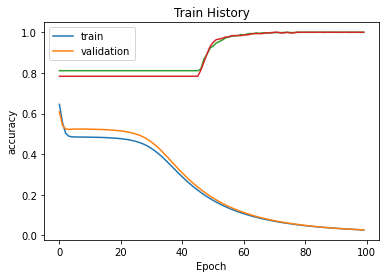

In [20]:
show_train_history(train_hist,'loss','val_loss')
show_train_history(train_hist,'accuracy','val_accuracy')

### &emsp;| (4) output df_bin

In [19]:
inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functors = [K.function([inp], [out]) for out in outputs]    # evaluation functions

bin_data = []
for r in x:
    layer_outs = [func([np.array([[r]])]) for func in functors]
    for i,l in enumerate (layer_outs):
        for n in l:
            l_f = [s for xs in n.tolist() for s in xs]
            if i == bin_col_layer-1: bin_data.append(change_to_one_zero(l_f,0.2))

In [20]:
df_b = pd.DataFrame(bin_data)
df_b["GB"] = y
df_b

,0,1,2,3,4,5,6,7,8,9,GB
0,0,0,1,0,0,0,1,0,1,0,1
1,1,1,0,1,0,0,0,0,0,0,0
2,1,1,0,1,0,0,0,0,0,0,0
3,1,1,0,1,0,0,0,0,0,0,0
4,1,1,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2995,1,1,0,1,0,0,0,0,0,0,0
2996,1,1,0,1,0,0,0,0,0,0,0
2997,1,1,0,1,0,0,0,0,0,0,0
2998,1,1,0,1,0,0,0,0,0,0,0


In [21]:
df_b.iloc[:,:n_bin_col].drop_duplicates().shape

(5, 10)

### &emsp;| (5) model vis

In [21]:
### important
import os
os.environ["PATH"] += os.pathsep + r'C:\Program Files\Graphviz\bin'

In [22]:
from ann_visualizer.visualize import ann_viz
ann_viz(model, title="Artificial Neural network - Model Visualization")

In [ ]:
import visualkeras
visualkeras.layered_view(model)

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
from keras.utils.vis_utils import plot_model
keras.utils.vis_utils.plot_model(model,to_file='model.png',)

## <span style='color:Orange'>generate rnd binary data<span style='color:Orange'>

In [27]:
num_of_points =3000
type_one_ratio = 0.1
num_of_col = 33

In [28]:
categorical_data = [random.randint(0, 2**num_of_col) for _ in range(num_of_points)]
bin_data = ["{0:b}".format(xs) for xs in categorical_data]
col_gb = [1]*int(num_of_points*type_one_ratio)+[0]*int(num_of_points*(1-type_one_ratio))

In [29]:
new_data = []
for b in bin_data:
    while len(b)!=num_of_col: b="0"+b
    new_data.append([int(bi) for bi in b])
df_bin = pd.DataFrame(new_data)
df_bin["GB"] = col_gb
df_bin

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,GB
0,0,0,1,0,0,1,0,1,1,0,...,1,1,1,0,1,0,1,0,0,1
1,1,0,1,1,1,0,0,1,1,1,...,1,0,0,1,1,0,0,0,0,1
2,1,0,1,0,0,1,0,0,1,0,...,1,1,1,1,0,0,0,1,0,1
3,0,0,0,0,0,0,1,1,0,0,...,1,1,0,0,1,1,0,0,0,1
4,0,1,0,1,0,1,0,0,1,0,...,1,0,0,1,0,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1,1,0,1,1,1,1,1,0,0,...,1,0,0,0,0,1,0,1,0,0
2996,0,0,1,1,0,0,1,1,1,1,...,0,0,1,1,0,1,0,1,0,0
2997,1,0,1,0,0,1,1,0,0,0,...,1,1,0,1,0,0,1,0,1,0
2998,0,1,1,0,0,0,1,1,1,1,...,0,1,1,0,0,1,0,0,1,0


In [194]:
int('100101', 2)

37

In [200]:
"{0:b}".format(37)

'100101'

# **2. Grouping related columns**
---

## &emsp; -> <span style='color:white'>mis<span style='color:white'>

### &emsp; * <span style='color:white'>import<span style='color:white'>

In [11]:
from sklearn import manifold, datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import cluster, datasets
from sklearn.metrics import mean_squared_error
from plotly.colors import n_colors
import numpy as np
import pygad
from random import sample 
import plotly.graph_objects as go
from collections import Counter 
from plotly.subplots import make_subplots
import collections

### &emsp; * <span style='color:white'>fun<span style='color:white'>

In [12]:
# # dimension reduction
# def generate_3d_df(X, y, c):
#     df = pd.DataFrame(X)
#     df.columns = [f"{c}-{i}" for i in range(1,4)]
#     df['GB'] = y
#     return df

# def encode_category(array): # change binary to category
#     for i in array:
#         if i != 0 and i!=1:
#             raise ValueError(f'all input needs to be 0 or 1 {array}')
#     x = [f"{n}" for n in array]
#     s = ''.join(x)
#     return int(s,2)

### &emsp; * <span style='color:white'>Class<span style='color:white'>

In [194]:
class Grouped_Data_PCA(Grouped_Data):
    # 建構式
    def __init__(self,original_data, name):
        self.name = name
        self.sep = original_data.sep
        self.df_bin = original_data.df_bin.copy()
        self.n_group = original_data.n_group
        self.bin_feat = len(self.df_bin.columns)-1
        
        self.pca = PCA(n_components=self.bin_feat)
        self.pca.fit(self.df_bin.T[:-1].T)
        
    # 方法(Method)
    def rearrange(self,):
        seleceted_cols, new_column= [],[]
        for p in range(0,self.n_group):
            X,Y = list(self.df_bin.columns),self.pca.components_[p]
            l = [x for _,x in sorted(zip(Y,X))]
            l.reverse()
            l = [ele for ele in l if ele not in seleceted_cols]
            [seleceted_cols.append(ele) for ele in l[0:self.sep[p+1]-self.sep[p]]]
        self.seq = seleceted_cols
        self.df_group = self.df_bin.copy()[seleceted_cols+[self.df_bin.columns[-1]]]
        self.df_group_ori = self.df_group.copy()
        # for i, s in enumerate( self.sep[:-1]):
        #     new_column.append(([f"PC{i+1}-{j}" for j in range(1,(self.sep[i+1] - s +1 ))]))
        # new_column = [item for sublist in new_column for item in sublist]+[self.df_bin.columns[-1]]
        # self.grouped_df.columns = new_column
        # return seleceted_cols
        
    # def name(self, name):
    #     self.name = name
        
    def plot_pca_weight_selection(self,):
        df = pd.DataFrame([f"{int(i)}." for i in range(1,self.bin_feat+1)],columns = [["<b>weight NO.</b>"],[""]])
        for i,sp in enumerate( self.sep[:-1]):
            X,Y = list(self.df_bin.columns), [abs(w) for w in self.pca.components_[i]]
            c = [x for _,x in sorted(zip(Y,X))]
            c.reverse()
            w = sorted(Y)
            w.reverse()
            w = ['{:.4f}'.format(elem) for elem in w]
            s = []
            for ele in c:
                if ele in self.seq[sp:self.sep[i+1]]:s.append("O")
                else: s.append("X")            
            
            df_pc = pd.DataFrame([c,w,s],).T
            df_pc.columns = [[f"<b> PC {i+1} </b>","",""],["<I>column</I>", "<I>weight</I>", "<I>select</I>"]]
            df = pd.concat([df, df_pc], axis=1)

        cell_color = cell_fill_color_pca(df, n_colors('rgb(255, 213, 213)', 'rgb(68, 198, 102)', 2, colortype='rgb'))
        fig = go.Figure(data=[go.Table(
            header=dict(values=df.columns,line_color='gray',fill_color='rgb(189, 215, 231)',align='center'),
            cells=dict(values=df.transpose().values.tolist(),    line_color="gray",fill_color=cell_color,font=dict(color='Black', size=13),align='center'))])
        fig.update_layout(title=f"PCA Column Grouping  <br><sup> {self.name} </sup> ",)
        return fig

In [13]:
class Grouped_Data:
    # 建構式
    def __init__(self,original_data, name):
        self.name = name
        self.sep = original_data.sep
        self.df_bin = original_data.df_bin.copy()
        self.n_group = original_data.n_group
        self.bin_feat = len(self.df_bin.columns)-1
        
    # 方法(Method)
    def rearrange(self,seq):
        if len(seq)!=len(self.df_bin.columns[:-1]): raise ValueError('A very specific bad thing happened.')
        self.rearrange_seq = seq
        self.df_group = self.df_bin.copy()[[self.df_bin.columns[:-1][s] for s in seq] + [str(self.df_bin.columns[-1])]] 
        self.df_group_ori = self.df_group.copy()
        
    def set_col(self, cols):
        new_col = []
        for i, s in enumerate( self.sep[:-1]):
            new_col.append([f"{cols[i]}-{n+1}" for n in range(0,self.sep[i+1]-s)] )
        new_col = [item for sublist in new_col for item in sublist]
        self.df_group.columns = new_col+ [str(self.df_bin.columns[-1])]

    def name(self, name):
        self.name = name

## <span style='color:Orange'>xyz group<span style='color:Orange'>

In [17]:
# sep and col setting
ori_data=ori_data
gd_xyz = Grouped_Data(ori_data, "xyz")
gd_xyz.rearrange([i for i in range(0,gd_xyz.bin_feat)])
gd_xyz.set_col(["x","y","z"])

## <span style='color:lightblue'>Randomly group<span style='color:lightblue'>

In [18]:
# sep and col setting
ori_data= ori_data
gd_rnd = Grouped_Data(ori_data, "rnd")
gd_rnd.rearrange(random.sample([i for i in range(0, len(gd_rnd.df_bin.columns[:-1]))],len(gd_rnd.df_bin.columns[:-1])))
gd_rnd.set_col([f"r{i+1}" for i in range(0, len(gd_rnd.sep[:-1]))])

## <span style='color:purple'>Binary K-means<span style='color:DarkOliveGreen'>

### &emsp; * <span style='color:white'>fun<span style='color:white'>

In [19]:
#!/usr/bin/env python
# kmeans.py using any of the 20-odd metrics in scipy.spatial.distance
# kmeanssample 2 pass, first sample sqrt(N)

from __future__ import division
import random
import numpy as np
from scipy.spatial.distance import cdist  # $scipy/spatial/distance.py
    # http://docs.scipy.org/doc/scipy/reference/spatial.html
from scipy.sparse import issparse  # $scipy/sparse/csr.py

__date__ = "2011-11-17 Nov denis"
    # X sparse, any cdist metric: real app ?
    # centres get dense rapidly, metrics in high dim hit distance whiteout
    # vs unsupervised / semi-supervised svm

#...............................................................................
def kmeans( X, centres, delta=.001, maxiter=10, metric="euclidean", p=2, verbose=1 ):
    """ centres, Xtocentre, distances = kmeans( X, initial centres ... )
    in:
        X N x dim  may be sparse
        centres k x dim: initial centres, e.g. random.sample( X, k )
        delta: relative error, iterate until the average distance to centres
            is within delta of the previous average distance
        maxiter
        metric: any of the 20-odd in scipy.spatial.distance
            "chebyshev" = max, "cityblock" = L1, "minkowski" with p=
            or a function( Xvec, centrevec ), e.g. Lqmetric below
        p: for minkowski metric -- local mod cdist for 0 < p < 1 too
        verbose: 0 silent, 2 prints running distances
    out:
        centres, k x dim
        Xtocentre: each X -> its nearest centre, ints N -> k
        distances, N
    see also: kmeanssample below, class Kmeans below.
    """
    if not issparse(X):
        X = np.asanyarray(X)  # ?
    centres = centres.todense() if issparse(centres) \
        else centres.copy()
    N, dim = X.shape
    k, cdim = centres.shape
    if dim != cdim:
        raise ValueError( "kmeans: X %s and centres %s must have the same number of columns" % (
            X.shape, centres.shape ))
    if verbose:
        print ("kmeans: X %s  centres %s  delta=%.2g  maxiter=%d  metric=%s" % (X.shape, centres.shape, delta, maxiter, metric))
    allx = np.arange(N)
    prevdist = 0
    for jiter in range( 1, maxiter+1 ):
        D = cdist_sparse( X, centres, metric=metric, p=p )  # |X| x |centres|
        xtoc = D.argmin(axis=1)  # X -> nearest centre
        distances = D[allx,xtoc]
        avdist = distances.mean()  # median ?
        if verbose >= 2:
            print ("kmeans: av |X - nearest centre| = %.4g" % avdist)
        if (1 - delta) * prevdist <= avdist <= prevdist \
        or jiter == maxiter:
            break
        prevdist = avdist
        for jc in range(k):  # (1 pass in C)
            c = np.where( xtoc == jc )[0]
            if len(c) > 0:
                centres[jc] = X[c].mean( axis=0 )
    if verbose:
        print ("kmeans: %d iterations  cluster sizes:" % jiter, np.bincount(xtoc))
    if verbose >= 2:
        r50 = np.zeros(k)
        r90 = np.zeros(k)
        for j in range(k):
            dist = distances[ xtoc == j ]
            if len(dist) > 0:
                r50[j], r90[j] = np.percentile( dist, (50, 90) )
        print ("kmeans: cluster 50 % radius", r50.astype(int))
        print ("kmeans: cluster 90 % radius", r90.astype(int))
            # scale L1 / dim, L2 / sqrt(dim) ?
    return centres, xtoc, distances

#...............................................................................
def kmeanssample( X, k, nsample=0, **kwargs ):
    """ 2-pass kmeans, fast for large N:
        1) kmeans a random sample of nsample ~ sqrt(N) from X
        2) full kmeans, starting from those centres
    """
        # merge w kmeans ? mttiw
        # v large N: sample N^1/2, N^1/2 of that
        # seed like sklearn ?
    N, dim = X.shape
    if nsample == 0:
        nsample = max( 2*np.sqrt(N), 10*k )
    Xsample = randomsample( X, int(nsample) )
    pass1centres = randomsample( X, int(k) )
    samplecentres = kmeans( Xsample, pass1centres, **kwargs )[0]
    return kmeans( X, samplecentres, **kwargs )

def cdist_sparse( X, Y, **kwargs ):
    """ -> |X| x |Y| cdist array, any cdist metric
        X or Y may be sparse -- best csr
    """
        # todense row at a time, v slow if both v sparse
    sxy = 2*issparse(X) + issparse(Y)
    if sxy == 0:
        return cdist( X, Y, **kwargs )
    d = np.empty( (X.shape[0], Y.shape[0]), np.float64 )
    if sxy == 2:
        for j, x in enumerate(X):
            d[j] = cdist( x.todense(), Y, **kwargs ) [0]
    elif sxy == 1:
        for k, y in enumerate(Y):
            d[:,k] = cdist( X, y.todense(), **kwargs ) [0]
    else:
        for j, x in enumerate(X):
            for k, y in enumerate(Y):
                d[j,k] = cdist( x.todense(), y.todense(), **kwargs ) [0]
    return d

def randomsample( X, n ):
    """ random.sample of the rows of X
        X may be sparse -- best csr
    """
    sampleix = random.sample( range( X.shape[0] ), int(n) )
    return X[sampleix]

def nearestcentres( X, centres, metric="euclidean", p=2 ):
    """ each X -> nearest centre, any metric
            euclidean2 (~ withinss) is more sensitive to outliers,
            cityblock (manhattan, L1) less sensitive
    """
    D = cdist( X, centres, metric=metric, p=p )  # |X| x |centres|
    return D.argmin(axis=1)

def Lqmetric( x, y=None, q=.5 ):
    # yes a metric, may increase weight of near matches; see ...
    return (np.abs(x - y) ** q) .mean() if y is not None \
        else (np.abs(x) ** q) .mean()

#...............................................................................
class Kmeans:
    """ km = Kmeans( X, k= or centres=, ... )
        in: either initial centres= for kmeans
            or k= [nsample=] for kmeanssample
        out: km.centres, km.Xtocentre, km.distances
        iterator:
            for jcentre, J in km:
                clustercentre = centres[jcentre]
                J indexes e.g. X[J], classes[J]
    """
    def __init__( self, X, k=0, centres=None, nsample=0, **kwargs ):
        self.X = X
        if centres is None:
            self.centres, self.Xtocentre, self.distances = kmeanssample(
                X, k=k, nsample=nsample, **kwargs )
        else:
            self.centres, self.Xtocentre, self.distances = kmeans(
                X, centres, **kwargs )

    def __iter__(self):
        for jc in range(len(self.centres)):
            yield jc, (self.Xtocentre == jc)


In [27]:
def score(C, n_clusters, cluster_size,n_variables):
    '''
    Function to assign a score to an ordered covariance matrix.
    High correlations within a cluster improve the score.
    High correlations between clusters decease the score.
    '''
    score = 0
    for cluster in range(n_clusters):
        inside_cluster = np.arange(cluster_size) + cluster * cluster_size
        outside_cluster = np.setdiff1d(range(n_variables), inside_cluster)

        # Belonging to the same cluster
        score += np.sum(C[inside_cluster, :][:, inside_cluster])

        # Belonging to different clusters
        score -= np.sum(C[inside_cluster, :][:, outside_cluster])
        score -= np.sum(C[outside_cluster, :][:, inside_cluster])

    return score


### &emsp; * <span style='color:white'>class<span style='color:white'>

In [138]:
class Grouped_Data_Corr(Grouped_Data):
    # 建構式
    def __init__(self,original_data, name):
        self.name = name
        self.sep = original_data.sep
        self.df_bin = original_data.df_bin.copy()
        self.n_group = original_data.n_group
        self.bin_feat = len(self.df_bin.columns)-1
        
        self.group_by_corr()
        # self.pca = PCA(n_components=self.bin_feat)
        # self.pca.fit(self.df_bin.T[:-1].T)
        
    # 方法(Method)
    def group_by_corr(self,):
        def score(C):
            '''
            Function to assign a score to an ordered covariance matrix.
            High correlations within a cluster improve the score.
            High correlations between clusters decease the score.
            '''
            score = 0
            for cluster in range(n_clusters):
                inside_cluster = np.arange(cluster_size) + cluster * cluster_size
                outside_cluster = np.setdiff1d(range(n_variables), inside_cluster)

                # Belonging to the same cluster
                score += np.sum(C[inside_cluster, :][:, inside_cluster])

                # Belonging to different clusters
                score -= np.sum(C[inside_cluster, :][:, outside_cluster])
                score -= np.sum(C[outside_cluster, :][:, inside_cluster])

            return score
        
        def swap_rows(C, var1, var2):
            '''
            Function to swap two rows in a covariance matrix,
            updating the appropriate columns as well.
            '''
            D = C.copy()
            D[var2, :] = C[var1, :]
            D[var1, :] = C[var2, :]

            E = D.copy()
            E[:, var2] = D[:, var1]
            E[:, var1] = D[:, var2]
            return E
        
        
        df_map = self.df_bin.iloc[:,:-1].corr()
        C = df_map.values
        n_variables = C.shape[0]
        n_clusters = self.n_group
        # To keep this example simple, each cluster will have a fixed size
        cluster_size = n_variables // n_clusters
        # Assign each variable to a cluster
        # belongs_to_cluster = np.repeat(range(n_clusters), cluster_size)
        # np.random.shuffle(belongs_to_cluster)
        # # This latent data is used to make variables that belong
        # # to the same cluster correlated.
        # latent = np.random.randn(n_clusters, n_samples)
        # variables = []
        # for i in range(n_variables):variables.append(np.random.randn(n_samples) + latent[belongs_to_cluster[i], :])
        # variables = np.array(variables)
        #............................................................................................
        initial_C = C
        initial_score = score(C)
        initial_ordering = np.arange(n_variables)
        # plt.figure()
        # plt.imshow(C, interpolation='nearest')
        # plt.title('Initial correlation map')
        # print ('Initial ordering:', initial_ordering)
        # print ('Initial covariance matrix score:', initial_score)
        # Pretty dumb greedy optimization algorithm that continuously
        # swaps rows to improve the score

        current_C = C
        current_ordering = initial_ordering
        current_score = initial_score

        max_iter = 1000
        for i in range(max_iter):
            # Find the best row swap to make
            best_C = current_C
            best_ordering = current_ordering
            best_score = current_score
            for row1 in range(n_variables):
                for row2 in range(n_variables):
                    if row1 == row2:
                        continue
                    option_ordering = best_ordering.copy()
                    option_ordering[row1] = best_ordering[row2]
                    option_ordering[row2] = best_ordering[row1]
                    option_C = swap_rows(best_C, row1, row2)
                    option_score = score(option_C)

                    if option_score > best_score:
                        best_C = option_C
                        best_ordering = option_ordering
                        best_score = option_score

            if best_score > current_score:
                # Perform the best row swap
                current_C = best_C
                current_ordering = best_ordering
                current_score = best_score
            else:
                # No row swap found that improves the solution, we're done
                break
        self.clusters = current_ordering
        # return current_ordering

### &emsp; * <span style='color:white'>specific distance function k-means<span style='color:white'>

In [28]:
from nltk.cluster.kmeans import KMeansClusterer
NUM_CLUSTERS = 2
data = <sparse matrix that you would normally give to scikit>.toarray()

kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(data, assign_clusters=True)

SyntaxError: invalid syntax (Temp/ipykernel_1220/15384282.py, line 3)

In [139]:
ori_data= ori_data
df_map = ori_data.df_bin.iloc[:,:-1].corr()
df_map.values.shape

(27, 27)

Initial ordering: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50]
Initial covariance matrix score: 7.211449771999682
Best ordering: [25  8 41 15 43 24  2 26 44 42  9 14 34 33  4  1 16 31 38 35 36 27 28 10
 13 32 11 39 37 29 30  0 40  7 45 21 12 20  5  3 18 49 17  6 22 48 46 47
 23 19 50]
Best score: 128.6646423596668
Cluster     [variables assigned to this cluster]
------------------------------------------------
Cluster 01  [25  8 41 15 43 24  2 26 44 42  9 14 34 33  4  1 16]
Cluster 02  [31 38 35 36 27 28 10 13 32 11 39 37 29 30  0 40  7]
Cluster 03  [45 21 12 20  5  3 18 49 17  6 22 48 46 47 23 19 50]


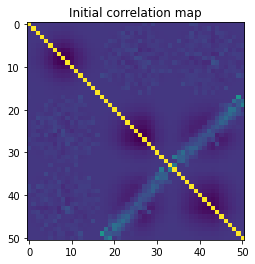

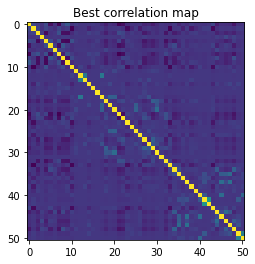

In [154]:
import numpy as np
from matplotlib import pyplot as plt

# C = np.cov(variables) # correlation map
C = df_map.values
n_variables = C.shape[0]
n_clusters = 3
def group_by_corr(self,):
    df_map = ori_data.df_bin.iloc[:,:-1].corr()
    C = df_map.values
    n_variables = C.shape[0]
    n_clusters = 3
    # To keep this example simple, each cluster will have a fixed size
    cluster_size = n_variables // n_clusters
    # Assign each variable to a cluster
    belongs_to_cluster = np.repeat(range(n_clusters), cluster_size)
    np.random.shuffle(belongs_to_cluster)
    # This latent data is used to make variables that belong
    # to the same cluster correlated.
    latent = np.random.randn(n_clusters, n_samples)
    variables = []
    for i in range(n_variables):variables.append(np.random.randn(n_samples) + latent[belongs_to_cluster[i], :])
    variables = np.array(variables)
    #............................................................................................
    initial_C = C
    initial_score = score(C)
    initial_ordering = np.arange(n_variables)
    # plt.figure()
    # plt.imshow(C, interpolation='nearest')
    # plt.title('Initial correlation map')
    # print ('Initial ordering:', initial_ordering)
    # print ('Initial covariance matrix score:', initial_score)
    # Pretty dumb greedy optimization algorithm that continuously
    # swaps rows to improve the score
    def swap_rows(C, var1, var2):
        '''
        Function to swap two rows in a covariance matrix,
        updating the appropriate columns as well.
        '''
        D = C.copy()
        D[var2, :] = C[var1, :]
        D[var1, :] = C[var2, :]

        E = D.copy()
        E[:, var2] = D[:, var1]
        E[:, var1] = D[:, var2]

        return E

    current_C = C
    current_ordering = initial_ordering
    current_score = initial_score

    max_iter = 1000
    for i in range(max_iter):
        # Find the best row swap to make
        best_C = current_C
        best_ordering = current_ordering
        best_score = current_score
        for row1 in range(n_variables):
            for row2 in range(n_variables):
                if row1 == row2:
                    continue
                option_ordering = best_ordering.copy()
                option_ordering[row1] = best_ordering[row2]
                option_ordering[row2] = best_ordering[row1]
                option_C = swap_rows(best_C, row1, row2)
                option_score = score(option_C)

                if option_score > best_score:
                    best_C = option_C
                    best_ordering = option_ordering
                    best_score = option_score

        if best_score > current_score:
            # Perform the best row swap
            current_C = best_C
            current_ordering = best_ordering
            current_score = best_score
        else:
            # No row swap found that improves the solution, we're done
            break
    return current_ordering
    # Output the result
    # plt.figure()
    # plt.imshow(current_C, interpolation='nearest')
    # plt.title('Best correlation map')
    # print ('Best ordering:', current_ordering)
    # print ('Best score:', current_score)
    # # print
    # print ('Cluster     [variables assigned to this cluster]')
    # print ('------------------------------------------------')
    # for cluster in range(n_clusters):print ('Cluster %02d  %s' % (cluster + 1, current_ordering[cluster*cluster_size:(cluster+1)*cluster_size]))

In [156]:
df = ori_data.df_bin
clusters = []
for i, s in enumerate( ori_data.sep[:-1]):
    the_cluster = current_ordering[s:ori_data.sep[i+1]]
    print([df.columns[c] for c in the_cluster])
    clusters.append([df.columns[c] for c in the_cluster])

['b-9', 'a-10', 'c-9', 'a-17', 'c-11', 'b-8', 'a-3', 'b-10', 'c-12', 'c-10', 'a-11', 'a-16', 'c-1', 'b-18', 'a-5', 'a-2', 'a-18']
['b-16', 'c-6', 'c-3', 'c-4', 'b-11', 'b-12', 'a-12', 'a-15', 'b-17', 'a-13', 'c-7', 'c-5', 'b-13', 'b-15', 'a-1', 'c-8', 'a-9']
['c-13', 'b-5', 'a-14', 'b-4', 'a-6', 'a-4', 'b-2', 'c-17', 'b-1', 'a-8', 'b-6', 'c-16', 'c-14', 'c-15', 'b-7', 'b-3', 'c-18']


In [140]:
# sep and col setting
ori_data=ori_data
gd_corr = Grouped_DataFrame_Corr(ori_data, "corr")
gd_corr.rearrange(gd_corr.clusters)
gd_corr.set_col(["c1","c2","c3"])

In [ ]:
plot_corr_column_grouping(gd)

## <span style='color:brown'>PCA weight group<span style='color:brown'>

### &emsp;&emsp; * <span style='color:white'>fun<span style='color:white'>

#### -sorting rule

In [37]:
### sorting rule
def sort_SmallToLarge(seq_l_data, data_l_data):  # from small to large
    seq_l = seq_l_data.copy()
    data_l = data_l_data.copy()
    for i in range(len(seq_l)):
        swap = i + np.argmin(seq_l[i:])
        (seq_l[i], seq_l[swap]) = (seq_l[swap], seq_l[i])
        (data_l[i], data_l[swap]) = (data_l[swap], data_l[i])
    return data_l

def sort_LargeToSmall(seq_l_data, data_l_data): # from large to small
    seq_l = seq_l_data.copy()
    data_l = data_l_data.copy()
    for i in range(len(seq_l)):
        swap = i + np.argmax(seq_l[i:])
        (seq_l[i], seq_l[swap]) = (seq_l[swap], seq_l[i])
        (data_l[i], data_l[swap]) = (data_l[swap], data_l[i])
    return data_l

def sort_normal(seq_l_data, data_l_data):  # make to be normal
    seq_l = solve_duplicates( seq_l_data.copy())
    data_l = data_l_data.copy()
    new_data = []
    while(len(seq_l)!=0):
        element = data_l[seq_l.index(max(seq_l))]
        # print(seq_l, data_l)
        # print("seq: ",max(seq_l)," / element: ",element)
        if len(seq_l) % 2 == 0:
            new_data.insert(0,element)
        else:
            new_data.append(element)
        # print("==>",new_data, "\n")
        
        del data_l[seq_l.index(max(seq_l))]
        seq_l.remove(max(seq_l))       
    return new_data

#### -pca finding

In [38]:
# group PCA by B or F, weight or ABS
def find_pca_selection_all(df_bin, abs_w,pca_cg, op = None): 
    df = df_bin.copy()
    n_pc, n_per_col= pca_cg["n_pc"], pca_cg["n_cols"] 
    d_pca= {}
    for i in range(0,len(pca.components_),1): # from 0 to n_pc
        col = df.columns[:-1].tolist().copy()
        if abs_w:seq = [abs(i) for i in pca.components_[i].tolist()] # weight ABS
        else:seq = [i for i in pca.components_[i].tolist()] # weight  
        w_c = sort_LargeToSmall(seq,col) # sorted weighted columns
        # record
        seq.sort(reverse = True)
        d_pca[f"PC {i+1}"] = [w_c.copy(), [ '%.1e' % elem for elem in seq ], ]

    df_record = pd.DataFrame([f"{int(i)}." for i in range(1,len(pca.components_)+1)],columns = [["weight NO."],[""]])
    # df_record = pd.DataFrame()
    for i,pc in enumerate (d_pca):
        d = None
        if op == "weight":
            d = d_pca[pc][1]
        elif op == "column":
            d = d_pca[pc][0] 
        # c,w = d_pca[pc][0],d_pca[pc][1]
        df_pc = pd.DataFrame([d]).T
        
        df_pc.columns = [[f"{pc}"],[op]]
        df_record = pd.concat([df_record, df_pc], axis=1)

    return df_record.T

def group_col_pca(df, d, abs_w,pca_cg):
    l_s_col,d_select = [],{} # already selected columns
    n_pc, n_cols = pca_cg["n_pc"], pca_cg["n_cols"] 
    # pc front or pc back
    if d == "F":s,e,g = 0,n_pc,1 
    elif d == "B": s,e,g = len(df.columns)-2,len(df.columns)-2-n_pc,-1  

    for i in range(s,e,g):
        col = df.columns[:-1].tolist().copy()
        if abs_w:seq = [abs(i) for i in pca.components_[i].tolist()] # weight ABS
        else:seq = [i for i in pca.components_[i].tolist()] # weight  
        w_c = sort_LargeToSmall(seq,col) # sorted weighted columns
        
        seq.sort(reverse = True)
        d_select[f"PC {i+1}"] = [w_c.copy(), [ '%.4f' % elem for elem in seq ]]# record


        n, n_col = 0, n_cols[abs(i-s)]
        while n<n_col:  # append none select col  
            while w_c[n] in l_s_col:
                w_c.remove(w_c[n])
            n = n+1
        for c in w_c[:n_col]:l_s_col.append(c) # memorized selected columns

    c_pc,s,t = [], 0, 0 # column selection
    for r in n_cols:
        t += r
        c_pc.append(l_s_col[s:t])
        s += r
        
    for i,pc in enumerate (d_select):
        l = []
        for j in d_select[pc][0]:
            if j in c_pc[i]:l.append("O")         
            else:l.append("X")             
        d_select[pc].append(l)

    df_bin_pc = df[[x for xs in c_pc for x in xs]+["GB"]]
    return df_bin_pc, d_select

# build pca on column
def pca_on_col(df_bin,n_col): 
    df = df_bin.copy()
    X = df.iloc[:, 0:len(df.columns)-1]
    y = df[df.columns[-1]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1224, train_size = .75,stratify=y,)
    
    #pca
    pca = PCA(n_components=n_col)
    pca.fit(X_train)
    return pca

def set_pca(df_bin,n_pc):
    pca_cg= {}
    pca_cg["n_bin_col"], pca_cg["n_pc"]= len(df_bin.columns[:-1]), n_pc
    if pca_cg["n_bin_col"]%pca_cg["n_pc"]!=0:
        n_per_col = int(n_bin_col/pca_cg["n_pc"]+1)
        pca_cg["n_cols"] = int(pca_cg["n_bin_col"]/n_per_col)*[n_per_col]+[int(pca_cg["n_bin_col"]%n_per_col)]
    else:
        pca_cg["n_cols"] = [int(pca_cg["n_bin_col"]/pca_cg["n_pc"])]*pca_cg["n_pc"]
    pca = pca_on_col(df_bin, pca_cg["n_bin_col"])
    return pca, pca_cg

### &emsp;&emsp; * <span style='color:white'>Class<span style='color:white'>

In [255]:
class Grouped_Data_PCA(Grouped_Data):
    # 建構式
    def __init__(self,original_data, name):
        self.name = name
        self.sep = original_data.sep
        self.df_bin = original_data.df_bin.copy()
        self.n_group = original_data.n_group
        self.bin_feat = len(self.df_bin.columns)-1
        
        self.pca = PCA(n_components=self.bin_feat)
        self.pca.fit(self.df_bin.T[:-1].T)
        
    # 方法(Method)
    def rearrange(self,):
        seleceted_cols, new_column= [],[]
        for p in range(0,self.n_group):
            X,Y = list(self.df_bin.columns)[:-1],[abs(w) for w in self.pca.components_[p]]
            l = [x for _,x in sorted(zip(Y,X))]
            l.reverse()
            l = [ele for ele in l if ele not in seleceted_cols]
            [seleceted_cols.append(ele) for ele in l[0:self.sep[p+1]-self.sep[p]]]
        self.seq = seleceted_cols
        self.df_group = self.df_bin.copy()[seleceted_cols+[self.df_bin.columns[-1]]]
        self.df_group_ori = self.df_group.copy()
        # for i, s in enumerate( self.sep[:-1]):
        #     new_column.append(([f"PC{i+1}-{j}" for j in range(1,(self.sep[i+1] - s +1 ))]))
        # new_column = [item for sublist in new_column for item in sublist]+[self.df_bin.columns[-1]]
        # self.grouped_df.columns = new_column
        # return seleceted_cols
        
    # def name(self, name):
    #     self.name = name
        
    def plot_pca_weight_selection(self,):
        df = pd.DataFrame([f"{int(i)}." for i in range(1,self.bin_feat+1)],columns = [["<b>weight NO.</b>"],[""]])
        for i,sp in enumerate( self.sep[:-1]):
            X,Y = list(self.df_bin.columns), [abs(w) for w in self.pca.components_[i]]
            c = [x for _,x in sorted(zip(Y,X))]
            c.reverse()
            w = sorted(Y)
            w.reverse()
            w = ['{:.4f}'.format(elem) for elem in w]
            s = []
            for ele in c:
                if ele in self.seq[sp:self.sep[i+1]]:s.append("O")
                else: s.append("X")            
            
            df_pc = pd.DataFrame([c,w,s],).T
            df_pc.columns = [[f"<b> PC {i+1} </b>","",""],["<I>column</I>", "<I>weight</I>", "<I>select</I>"]]
            df = pd.concat([df, df_pc], axis=1)

        cell_color = cell_fill_color_pca(df, n_colors('rgb(255, 213, 213)', 'rgb(68, 198, 102)', 2, colortype='rgb'))
        fig = go.Figure(data=[go.Table(
            header=dict(values=df.columns,line_color='gray',fill_color='rgb(189, 215, 231)',align='center'),
            cells=dict(values=df.transpose().values.tolist(),    line_color="gray",fill_color=cell_color,font=dict(color='Black', size=13),align='center'))])
        fig.update_layout(title=f"PCA Column Grouping  <br><sup> {self.name} </sup> ",)
        return fig

#### -plot

In [217]:
def cell_fill_color_pca(df,colors):
    def OX_to_num(s):
        l = []
        for c in s:
            if c == "O":l.append(1)
            else: l.append(0)
        return l  
    main_cell = [[np.array(colors)[OX_to_num(df.transpose().values.tolist()[col])]]*3 for col in range(3,12,3)]
    pca_color = [['rgb(255.0, 255, 255)']*len(df)] + [x for xs in main_cell for x in xs]
    return pca_color
    
def plot_pca_weight_selection(d_pca):
    df = pd.DataFrame([f"{int(i)}." for i in range(1,n_bin_col+1)],columns = [["<b>weight NO.</b>"],[""]])
    for pc in d_pca:
        c,w,s = d_pca[pc][0],d_pca[pc][1],0#,d_pca[pc][2]
        df_pc = pd.DataFrame([c,w,s],).T
        df_pc.columns = [[f"<b> {pc} </b>","",""],["<I>column</I>", "<I>weight</I>", "<I>select</I>"]]
        df = pd.concat([df, df_pc], axis=1)

    cell_color = cell_fill_color_pca(df, n_colors('rgb(255, 213, 213)', 'rgb(68, 198, 102)', 2, colortype='rgb'))
    # grid_color = header_grid_color_pca(df, n_colors('rgb(189, 215, 231)', 'gray', 2, colortype='rgb'))
    
    fig = go.Figure(data=[go.Table(
        header=dict(values=df.columns,
                    line_color='gray',
                    fill_color='rgb(189, 215, 231)',
                    align='center'),
        cells=dict(values=df.transpose().values.tolist(),    
                   line_color="gray",
                   fill_color=cell_color,
                   font=dict(color='Black', size=13),
                   # line_color='gray',fill_color='lavender',
                   align='center'))
    ])
    fig.update_layout(
    title=f"PCA Column Grouping  <br><sup> {df_name} </sup> ",
    )
    return fig

def plot_pca_weight_changes_table(pca):
    df_var = pd.DataFrame(np.vstack(([ '%.3e' % elem for elem in pca.explained_variance_],
                                     [ '%.3e' % elem for elem in pca.explained_variance_ratio_],
                                     [ '%.5f' % elem for elem in pca.explained_variance_ratio_.cumsum() ])).T, 
                          columns = ["<b>explained variance</b>","<b>explained variance ratio</b>", "<b>cumulated explained variance ratio</b>"])
    df_var = df_var.set_index(pd.Series([f"PC {i}" for i in range(1, len(pca.components_)+1)], name = "PCs" ))

    color = ['white', 'antiquewhite','lightpink', 'rgb(189,252,201)']
    fig = go.Figure(data=[go.Table(
        columnwidth = [80,400],
        header=dict(values=df_var.reset_index().columns,
                    line_color='gray',
                    fill_color='rgb(189, 215, 231)',
                    align='center'),
        cells=dict(values=df_var.reset_index().T,    
                   line_color="gray",
                   fill_color=color,
                   font=dict(color='Black', size=13),
                   # line_color='gray',fill_color='lavender',
                   align=['left', 'center'],))
    ])
    fig.update_layout(title=f"PCA weight changes <br><sup> {df_name} </sup> ",)
    return fig


def plot_pca_weight_changes_line(pca):
    x_label = [f"PC {i}" for i in range(1,pca.n_components+1)]
    exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)
    exp_var = pca.explained_variance_
    bar = go.Bar(x=x_label, y=exp_var, name = "explained variance",marker=dict(color = "blue", opacity=0.8))
    line = go.Scatter(x=x_label, y=exp_var_cumul, name="explained variance ratio CDF",
                     line = dict(color='olivedrab', width=3),  fill='tozeroy')#,  mode= 'none')

    fig = go.FigureWidget(make_subplots(specs=[[{"secondary_y": True}]]))
    fig.add_trace(bar,secondary_y= False)
    fig.add_trace(line,secondary_y= True)
    fig.update_layout(title = " ",barmode='group', 
                      # bargap=0.0,bargroupgap=0.0,
                      legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=0.95))
    return fig

### &emsp;| (1) build PCA

In [257]:
ori_data= ori_data
gd_PCA = Grouped_Data_PCA(ori_data, "PCA")
gd_PCA.rearrange()
gd_PCA.set_col(["pc1","pc2","pc3"])

### &emsp;| (2) PCA grouped binary df

In [451]:
df = df_find
fig = go.Figure(data=[go.Table(
    # columnwidth = [80,400],
    header=dict(values=df.reset_index().columns,
                line_color='gray',
                fill_color='rgb(189, 215, 231)',
                align='center'),
    cells=dict(values=df.reset_index().T,    
               line_color="gray",
               # fill_color="",
               font=dict(color='Black', size=13),
               # line_color='gray',fill_color='lavender',
               align=['left', 'center'],))
])
fig.update_layout(xaxis=dict(rangeslider=dict(visible=True),type="linear"))
fig.update_layout(title=f"PCA weight changes <br><sup> {df_name} </sup> ",)

NameError: name 'df_find' is not defined

In [28]:
from IPython.display import HTML
df = df_find
 
df_html = df.to_html()
 
html_file = open('netflix.html', 'w', encoding='utf-8')  
html_file.write(df_html)
html_file.close()
# HTML(df.to_html(classes='table table-stripped'))

import pandas as pd
from pretty_html_table import build_table
df = df_find.T
html_table_blue_light = build_table(df, 'blue_light',index=False, width_dict=[200,800,20,80], text_align='center',)
# print(html_table_blue_light)
with open('styled_table.html', 'w') as f:
    f.write(html_table_blue_light)

NameError: name 'df_find' is not defined

In [29]:
df_find = find_pca_selection_all(df_bin, True, pca_cg)

In [103]:
shp_name = "shape 1"
n_bin_col = 9
path  = rf"C:\Users\User\Desktop\Terry\Data\Output\3D Fig\{shp_name}\BC {n_bin_col}"
if not os.path.exists(path): os.makedirs(path)
df_f.to_csv(rf"{path}\find.csv",index = True)

## <span style='color:DarkOliveGreen'>GA(supervised)<span style='color:DarkOliveGreen'>

### &emsp;&emsp; * <span style='color:white'>fun<span style='color:white'>

####  &emsp;  &emsp; -GA

#####  &emsp;  &emsp;  &emsp; &emsp;  --record

In [ ]:
# record 
def on_generation(ga):
    print("Generation", ga.generations_completed)
    print(ga.population)
    
def on_fitness(ga, population_fitness):
    avg = sum(ga_instance.last_generation_fitness)/len(ga_instance.last_generation_fitness)
    maximul = max(ga_instance.last_generation_fitness)
    ft_iteration_avg.append(avg)
    ft_iteration_best.append(maximul)
    if ft_so_far_the_best:
        if max(ft_so_far_the_best)<=maximul:ft_so_far_the_best.append(maximul)
        else:ft_so_far_the_best.append(ft_so_far_the_best[-1])
    else:ft_so_far_the_best.append(maximul)

#####  &emsp;  &emsp;  &emsp; &emsp;  --crossover

In [16]:
# crossover
def order_crossover(parents, offspring_size, ga_instance):
    offspring = []
    idx = 0
    while len(offspring) != offspring_size[0]:
        p1 = list(parents[idx % parents.shape[0], :].copy())
        p2 = list(parents[(idx + 1) % parents.shape[0], :].copy())
        
        cut_pt = sorted(sample(p1,2))
        p1_ele = [p1[e] for e in range(cut_pt[0],cut_pt[1]+1)]
        p2_ele = [p for p in p2 if p not in p1_ele]

        offspring.append(p2_ele[0:cut_pt[0]]+p1_ele+p2_ele[cut_pt[0]:])
        idx += 1
    return np.array(offspring)

def position_based_crossover(parents, offspring_size, ga_instance):
    offspring = []
    idx = 0
    while len(offspring) != offspring_size[0]:
        p1 = list(parents[idx % parents.shape[0], :].copy())
        p2 = list(parents[(idx + 1) % parents.shape[0], :].copy())
        
        cut_pts = sorted(sample(p1,sample(p1,1)[0]))
        p1_ele = [p1[e] for e in cut_pts]
        p2_ele = [p for p in p2 if p not in p1_ele]
        
        c,e=[],0
        for i in cut_pts:
            c,e = p2_ele.insert(i,p1_ele[e]),e+1
            
        offspring.append(p2_ele)
        idx += 1

    return np.array(offspring)

#####  &emsp;  &emsp;  &emsp; &emsp;  --mutation

In [17]:
# mutation
def swap_mutation(offspring, ga_instance):
    for chromosome_idx in range(offspring.shape[0]):
        c = list(offspring[chromosome_idx])
        mut_pt = sorted(sample(c,2))
        c[mut_pt[0]], c[mut_pt[1]] = c[mut_pt[1]], c[mut_pt[0]]
        offspring[chromosome_idx] = np.array(c)
    return offspring

def scramble_mutation(offspring, ga_instance):
    for chromosome_idx in range(offspring.shape[0]):
        c = list(offspring[chromosome_idx])
        cut_pt = sorted(sample(c,2))
        scrable_ele = c[cut_pt[0]:cut_pt[1]+1]
        offspring[chromosome_idx] = np.array(c[0:cut_pt[0]]+sample(scrable_ele,len(scrable_ele))+c[cut_pt[1]+1:])
    return offspring

#####  &emsp;  &emsp;  &emsp; &emsp;  --fittness

In [19]:
# fittness

def min_type1_dis_fitness(solution, solution_idx): # need df_1 and l_col
    n_data = []
    n_oreder = [l_col[i] for i in solution]
    df_new = df_1[n_oreder]
    for r in range(0,len(df_1)):
        # df_1.iloc[r,:]
        n_data.append(encode_category(df_new.iloc[r,:]))
    return -mean_squared_error(n_data, [sum(n_data)/len(n_data)]*len(n_data))

def max_ssb_ssw_fitness(solution, solution_idx):
    X,Y = [],[]
    n_oreder = [l_col[i] for i in solution]
    df_0_new = df_0[n_oreder]
    df_1_new = df_1[n_oreder]
    for r in range(0,len(df_0)):
        X.append(encode_category(df_0_new.iloc[r,:]))
    for r in range(0,len(df_1)):
        Y.append(encode_category(df_1_new.iloc[r,:]))
    SST = sum([(t - np.mean(X+Y))**2 for t in X+Y])
    SSE = sum([(x - np.mean(X))**2 for x in X])+sum([(y - np.mean(Y))**2 for y in Y])
    SSB = SST-SSE
    return SSB/SSE

####  &emsp;  &emsp; -plot

In [658]:
def plot_GA_evolve(ft_iteration_best,ft_so_far_the_best,ft_iteration_avg):
    # Create traces
    x = [i for i in range(1,num_generations+1)]
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=x, y=ft_iteration_best,
                        mode='lines',name='iteration the best'))
    fig.add_trace(go.Scatter(x=x, y=ft_so_far_the_best,
                        mode='lines',name='so far the best'))
    fig.add_trace(go.Scatter(x=x, y=ft_iteration_avg,
                        mode='lines', name='iteration average'))
    fig.update_layout(title="Binary column permutation",xaxis_title="Generation",yaxis_title="Fitness",
                      legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1))
    return fig
# fig.show()

In [659]:
def arrange_col_by_order(df_bin, order):
    n_data = []
    n_oreder = list(order)
    df_new = df_bin.copy()[n_oreder]
    for r in range(0,len(df_bin)):
        n_data.append(encode_category(df_new.iloc[r,:]))
    df_new = pd.DataFrame(n_data)
    df_new["GB"] = df_bin.GB
    return df_new

def get_cumulated_points(df):
    ordered_dict = collections.OrderedDict(sorted(Counter(df[df.columns[0]]).items()))
    x,y = [],[]
    cum = 0
    for c in ordered_dict:
        cum+=ordered_dict[c]
        x.append(c)
        y.append(cum)
    new_y = []
    for o in y:
        if o and max(y)!=0: new_y.append(o/max(y))
        else:new_y.append(0)
    return x,new_y

def plot_encode_axis(df, name):
    fig = make_subplots(rows=2, cols=1, shared_xaxes='all')#, column_widths=[0.7, 0.3])
    df_1 = df.loc[df.GB==1]
    df_0 = df.loc[df.GB==0]
    x1,y1 = get_cumulated_points(df_1)
    x0,y0 = get_cumulated_points(df_0)

    fig.add_trace(go.Scatter(x=df_0[df.columns[0]],y=len(df_0)*[f"GB=0"],mode='markers', marker=dict(color="blue"),
                             name=f"GB=0, [{len(df_0)}]",),row=1, col=1)
    fig.add_trace(go.Scatter(x=df_1[df.columns[0]],y=len(df_1)*["GB=1"],mode='markers', marker=dict(color="red"),
                             name=f"GB=1, [{len(df_1)}]",),row=1, col=1)

    fig.add_trace(go.Scatter(x=x1, y=y1,mode='lines',marker_color='red',name='cum 1')
                  ,row=2, col=1)
    fig.add_trace(go.Scatter(x=x0, y=y0,mode='lines',marker_color='blue',name='cum 2')
                  ,row=2, col=1)

    for trace in fig['data']: 
        if("cum" in trace['name']): trace['showlegend'] = False
    fig.update_layout(title=f"Encoding result, {name}",xaxis2_title="Categorical variable",#yaxis_title="Type",
                      legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1))
    return fig

### &emsp;| (1) build GA model

In [300]:
# GA settings
num_genes = len(df_bin.columns[:-1])
init_range_low = 0
init_range_high = num_genes

num_generations = 30
sol_per_pop = 10

In [301]:
# Dataframe para
df = df_bin
df_0 = df_bin.loc[df_bin.GB==0].copy()
df_1 = df_bin.loc[df_bin.GB==1].copy()
l_col = df_bin.columns[:-1].tolist()

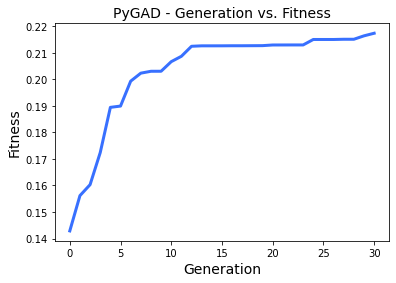

In [302]:
ft_iteration_avg = []
ft_iteration_best = []
ft_so_far_the_best = []

crossover_type = position_based_crossover
mutation_type = scramble_mutation
fitness_func = max_ssb_ssw_fitness

ga_instance = pygad.GA(num_generations=num_generations,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       
                       parent_selection_type="sss",
                       
                       crossover_type=crossover_type,
                       crossover_probability=0.8,
                       
                       mutation_type=mutation_type,
                       mutation_probability = 0.2,
                         
                       num_parents_mating=2,
                       fitness_func=fitness_func,
                       
                       gene_type=int,
                       gene_space=[i for i in range(init_range_low,init_range_high)],
                       
                       on_fitness = on_fitness,
                       allow_duplicate_genes=False,
                      )
ga_instance.run()
ga_instance.plot_result()
print()

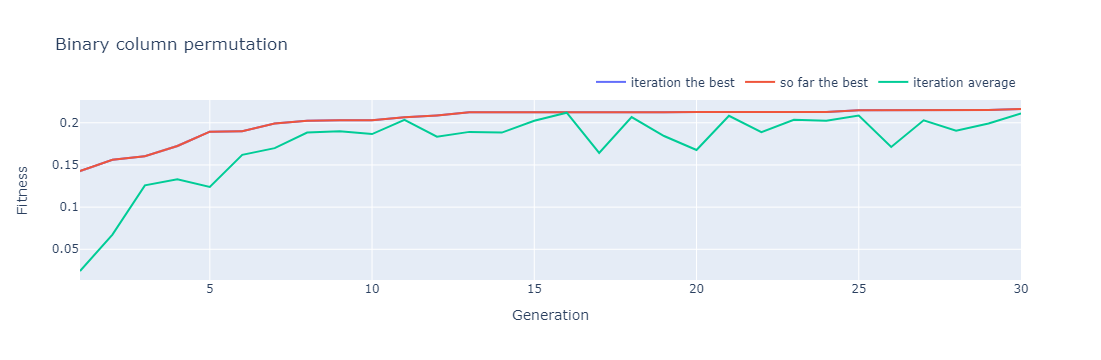

In [303]:
fig = plot_GA_evolve(ft_iteration_best,ft_so_far_the_best,ft_iteration_avg)
fig

In [92]:
fig.write_html(r"C:\Users\User\Desktop\Terry\Data\Output\3D Fig\GA evovle.html")

### &emsp;| (2) encoding result

In [607]:
df_ori = arrange_col_by_order(df_bin,df_bin.columns[:-1])
plot_encode_axis(df_ori, "(original sequence)")# df_new

NameError: name 'arrange_col_by_order' is not defined

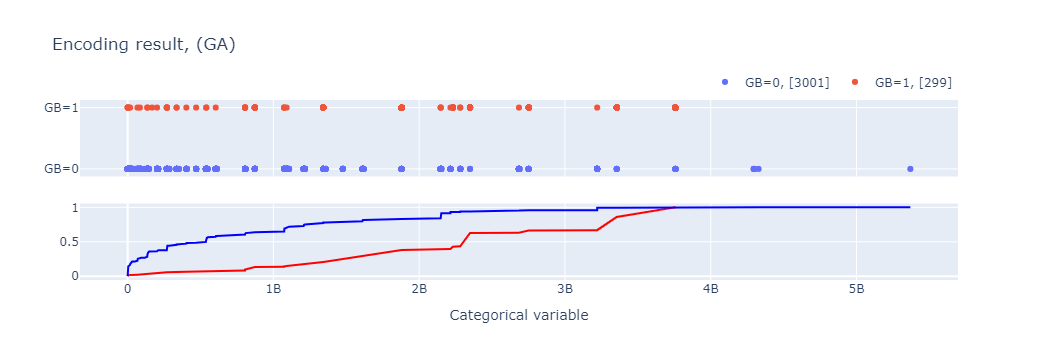

In [305]:
df_ga = arrange_col_by_order(df_bin,[l_col[i] for i in list(ga_instance.best_solution()[0])])
plot_encode_axis(df_ga, "(GA)")

## <span style='color:purple'>Brutal Force(supervised)<span style='color:DarkOliveGreen'>

In [46]:
import itertools

In [ ]:
per = list(itertools.permutations([i for i in range(0, len(df_bin.columns[:-1]))]))
fitness = [fitness_func(f,_) for f in per]

In [ ]:
pd.DataFrame([per,fitness], index = ["combination", "fitness"]).T

In [ ]:
max(fitness)

# **3. Encoding**
---

## &emsp; -> <span style='color:white'>mis<span style='color:white'>

### &emsp; * <span style='color:white'>import<span style='color:white'>

In [42]:
import collections
from sklearn.preprocessing import Normalizer
import ipywidgets as widgets
from ipywidgets import VBox, HBox, Label, Button
from ipywidgets import IntSlider
import random
from sklearn import manifold, datasets
from sklearn.decomposition import PCA
import os
import plotly.io as pio
import random
pio.templates.default = "none"  

### &emsp; * <span style='color:white'>fun<span style='color:white'>

####  &emsp;  &emsp; -encoding

#####  &emsp;  &emsp;  &emsp; &emsp;  --seq, rule, encode

In [43]:
### sequence
# def cal_list_dos(X): # calculate distance ( from average to 0.5 )
#     bal_list = []
#     avg_list = cal_list_avg(X)
#     for avg in avg_list: 
#         bal_list.append(abs(avg-0.5))
#     return bal_list 
def seq_sum(df): 
    return [sum(df[c]) for c in df][:-1]

def seq_ID(df):
    return [a for a in range(0,len(df.T)-1)]

def seq_rnd(df): 
    ran = [a for a in range(0,len(df.T)-1)]
    random.Random().shuffle(ran)
    return ran 

def seq_ratio(df): 
    df_1 = df.loc[df[df.columns[-1]] == 1]
    ratio = []
    for i,col in enumerate(df.T[:-1].values): 
        # print(sum(col),sum(df_1.iloc[:,i]),sum(df_1.iloc[:,i])/sum(col))
        ratio.append(sum(df_1.iloc[:,i])/sum(col))
    return ratio

### sorting rule
def sort_SmallToLarge(seq_l_data, data_l_data):  # from small to large
    seq_l,data_l = seq_l_data.copy(),data_l_data.copy()
    for i in range(len(seq_l)):
        swap = i + np.argmin(seq_l[i:])
        (seq_l[i], seq_l[swap]) = (seq_l[swap], seq_l[i])
        (data_l[i], data_l[swap]) = (data_l[swap], data_l[i])
    return data_l

def sort_LargeToSmall(seq_l_data, data_l_data): # from large to small
    seq_l,data_l = seq_l_data.copy(),data_l_data.copy()
    for i in range(len(seq_l)):
        swap = i + np.argmax(seq_l[i:])
        (seq_l[i], seq_l[swap]) = (seq_l[swap], seq_l[i])
        (data_l[i], data_l[swap]) = (data_l[swap], data_l[i])
    return data_l

def sort_normal(seq_l_data, data_l_data):  # make to be normal
    seq_l,data_l = solve_duplicates( seq_l_data.copy()),data_l_data.copy()
    new_data = []
    while(len(seq_l)!=0):
        element = data_l[seq_l.index(max(seq_l))]
        if len(seq_l) % 2 == 0:new_data.insert(0,element)
        else:new_data.append(element)
        del data_l[seq_l.index(max(seq_l))]
        seq_l.remove(max(seq_l))       
    return new_data

### encoding methods
def encode_category(array):
    for i in array:
        if i != 0 and i!=1:
            raise ValueError(f'all input needs to be 0 or 1 {array}')
    x = [f"{n}" for n in array]
    s = ''.join(x)
    return int(s,2)

def encode_grid(array):
    for i in array:
        if i != 0 and i!=1:
            raise ValueError(f'all input needs to be 0 or 1 {array}')
    if sum(array) != 1:
        raise ValueError(f'sum of input must be 1 {array}')      
    d = 1
    for i in array:
        if i == 1:
            break
        d+=1
    return len(array) - d

#####  &emsp;  &emsp;  &emsp; &emsp;  --main funs

In [44]:
def perform_encoding(df_data, seq_fun, encode_fun, sort_fun, sep_list=None, new_col_name=None):
    df = df_data.copy()
    if sep_list == None and new_col_name == None:
        sep_list, new_col_name = get_sep_and_new_col_list(df)
    seq = seq_fun(df.values)
    new_data = []
    for row in df.values: 
        new_row_list = [] 
        for i in range(0, len(sep_list)-1):
            arr = []
            b = seq[sep_list[i]:sep_list[i+1]]
            r = row[sep_list[i]:sep_list[i+1]]      
            arr = sort_fun(b,r.tolist())
            num = encode_fun(arr)
            new_row_list.append(num)
            
        new_data.append(new_row_list)
    
    # make new dataframe
    df_new = pd.DataFrame(new_data)
    df_new.columns = new_col_name
    df_new = df_new.set_index(df.index) 
    df_new["GB"] = df["GB"]
    return df_new

def get_sep_and_new_col_list(df_data):
    df = df_data.copy()
    col = df.columns[:-1]
    pre_c = col[0].split('-')[0]

    sep_list = [0]
    new_col_name = [pre_c]
    for i in range(0,len(col)):
        new_c = col[i].split('-')[0]
        if pre_c != new_c:
            sep_list.append(i)
            new_col_name.append(new_c)
        pre_c = new_c
    sep_list.append(len(col))
    return sep_list, new_col_name

def generate_new_sep_and_feat(n_cols):   
    feat = [chr(945+i) for i in range(0, len(n_cols))]
    sep,sum_ = [0],0
    for s in n_cols:
        sum_ += s
        sep.append(sum_)  
    return sep, feat

def solve_duplicates(arr_data):
    arr = arr_data.copy()
    interval = 1/len(arr)
    duplicates = [item for item, count in collections.Counter(arr).items() if count > 1]
    for d in duplicates:
        for i in range(0,len(arr)):
            if arr[i] == d:
                arr[i] = d + i*interval
    # print(arr)
    return arr

# change df range
def rerange(df_data, with_in_01):
    df = df_data.copy()
    n_df =(df-df.min())/(df.max()-df.min())

    if  with_in_01==False:
        for i in range(0, len(sep_list)-1):
            g = sep_list[i+1]-sep_list[i]
            n_df.iloc[:,i] = n_df.iloc[:,i] * g

    return n_df

####  &emsp;  &emsp; -compare plot

#####  &emsp;  &emsp;  &emsp; &emsp;  --3D, corrmap, axis plot

In [150]:
def plot_encoded_axis(encoder, df_encode, df_sorted_encode):
    fig = make_subplots(rows=3, cols=2,subplot_titles=(['Encode','Sorted Encoded']))
    
    # adding df_cont trace
    dict_df = {"Encode":df_encode, "Sorted Encoded":df_sorted_encode}
    for key in dict_df:  
        df = dict_df[key]
        cols_id = list(dict_df.keys()).index(key)+1
        for j in range (0, len(df.columns)-1):
            X = df[df.columns[j]].loc[df.GB == 0]
            fig.add_trace(go.Histogram( x=X, opacity=1,showlegend=False, marker_color='Blue', marker=dict(color = df.GB, colorscale='Bluered',opacity = 0.8)),row=j+1, col=cols_id)
            X = df[df.columns[j]].loc[df.GB == 1]
            fig.add_trace(go.Histogram( x=X, opacity=1,showlegend=False, marker_color='Red', marker=dict(color = df.GB, colorscale='Bluered',opacity = 0.8)),row=j+1, col=cols_id)    
            
    fig.update_layout(barmode='stack',title = f" Reindex Encoded Result<br><sup> {encoder.name} </sup> ")
    return fig

def plot_bin_axis(ori_data, encoder):
    fig = make_subplots(rows=3, cols=3,subplot_titles=(['Conti.','Bin.','Sorted Bin.']))
    # adding df_cont trace
    df = ori_data.df_read
    for j in range (0, len(df.columns)-1):
        X = df[df.columns[j]].loc[df.GB == 0]
        fig.add_trace(go.Histogram( x=X, opacity=1,showlegend=False, marker_color='Blue', marker=dict(color = df.GB, colorscale='Bluered',opacity = 0.8)),row=j+1, col=1)
        X = df[df.columns[j]].loc[df.GB == 1]
        fig.add_trace(go.Histogram( x=X, opacity=1,showlegend=False, marker_color='Red', marker=dict(color = df.GB, colorscale='Bluered',opacity = 0.8)),row=j+1, col=1)

    dict_df = {"Encode":ori_data.df_bin, "Sorted Encoded":encoder.df_sort}
    for key in dict_df:  
        df = dict_df[key]
        cols_id = list(dict_df.keys()).index(key)+2
        count_list = []
        for i in range(0, len(ori_data.sep)-1):
            df_bin_new = df.iloc[:,ori_data.sep[i]:ori_data.sep[i+1]]
            count_0, count_1,x= [],[],[]
            for c in df_bin_new:
                x.append(c)
                count_0.append(df_bin_new.loc[df["GB"] == 0][c].sum())
                count_1.append(df_bin_new.loc[df["GB"] == 1][c].sum())
            fig.add_trace(go.Histogram(nbinsx=len(ori_data.sep)-1, histfunc="sum", y = count_0, x=x,showlegend=False, marker_color='Blue'),row=i+1, col=cols_id)
            fig.add_trace(go.Histogram(nbinsx=len(ori_data.sep)-1, histfunc="sum", y = count_1, x=x,showlegend=False, marker_color='Red'),row=i+1, col=cols_id)
            
    fig.update_layout(barmode='stack',title = f"Binary Axis Distribution <br><sup> {encoder.name} </sup> ")
    return fig

In [46]:
def plot_3d(ori_data, encoder, df_encode):
    list_name = [f'Original {ori_data.df_read.drop_duplicates().shape}',
     f'Encoded {df_encode.drop_duplicates().shape}']
    df_dict = {list_name[0]:ori_data.df_read, list_name[1]:df_encode}
    dict_key = list(df_dict.keys())
    
    alpha = 0.3
    fig = make_subplots(rows=2, cols=2,specs=[[{'type': 'surface'}, {'type': 'surface'}],
                                              [{'type': 'surface'}, {'type': 'surface'}]],
                        subplot_titles=(dict_key+[f"PCA on {dict_key[0]}", f"PCA on {dict_key[1]}"]))
    # original scatter
    for k in range (0, len(dict_key)):
        df = df_dict[dict_key[k]]
        df1 = df.loc[df[df.columns[-1]] == 1]
        df0 = df.loc[df[df.columns[-1]] == 0]
        GB_1 = go.Scatter3d(x=df1[df.columns[0]], y=df1[df.columns[1]], z=df1[df.columns[2]],mode='markers', marker=dict(size=3, color = "red", opacity=1), showlegend=True, name = "GB_1")#,legendgroup=k,)
        GB_0 = go.Scatter3d(x=df0[df.columns[0]], y=df0[df.columns[1]], z=df0[df.columns[2]],mode='markers', marker=dict(size=3, color = "blue", opacity=0.5), showlegend=True, name = "GB_0")#,legendgroup=k,)
        fig.add_trace(GB_1,row=1, col=k+1)
        fig.add_trace(GB_0,row=1, col=k+1)
    # PCA line
    for k in range (0, len(dict_key)):  
        df = df_dict[dict_key[k]]
        data,target = df.iloc[:,:-1],df.iloc[:,-1:]
        pca = PCA(n_components=3).fit(data)
        X_reduced = pca.transform(data)
        
        x_reduce = go.Scatter3d(x = X_reduced[:,0],y = X_reduced[:,1],z = X_reduced[:,2],
                                    mode='markers', marker=dict(size=2,colorscale='Bluered',color= df.GB,  opacity=alpha))
        var1 = go.Scatter3d( x = [0,pca.components_.T[0][0]],y = [0,pca.components_.T[0][1]],z = [0,pca.components_.T[0][2]],
                            marker = dict( size = 1,color = "rgb(84,48,5)",),
                            line = dict( color = "red",width = 6),
                            legendgroup=f"group{k+1}",
                            name = list(df.columns)[0])
        var2 = go.Scatter3d( x = [0,pca.components_.T[1][0]],y = [0,pca.components_.T[1][1]],z = [0,pca.components_.T[1][2]],
                            marker = dict( size = 1,color = "rgb(84,48,5)"),
                            line = dict( color = "green",width = 6),
                            legendgroup=f"group{k+1}",
                            name = list(df.columns)[1])
        var3 = go.Scatter3d( x = [0,pca.components_.T[2][0]],y = [0,pca.components_.T[2][1]],z = [0,pca.components_.T[2][2]],
                            marker = dict( size = 1,color = "rgb(84,48,5)"),
                            line = dict( color = "blue",width = 6),
                            legendgroup=f"group{k+1}",
                            name = list(df.columns)[2]) 
        fig_data = [x_reduce, var1, var2, var3]
        fig.add_trace(x_reduce,row=2, col=k+1)
        fig.add_trace(var1,row=2, col=k+1)    
        fig.add_trace(var2,row=2, col=k+1) 
        fig.add_trace(var3,row=2, col=k+1)
        
    fig.update_layout(title_text=" " , title_x=0.5)
    fig.update_layout(xaxis =  {'showgrid': False},yaxis = {'showgrid': True},
                      scene2=dict(xaxis_title='α',yaxis_title='β',zaxis_title='γ'),
                      scene3=dict(xaxis_title='PC 1',yaxis_title='PC 2',zaxis_title='PC 3'),
                      scene4=dict(xaxis_title='PC 1',yaxis_title='PC 2',zaxis_title='PC 3'),
                      title_text=f'Scatter Plot  <br><sup>{encoder.name}</sup> ',)
    
    labels_to_show_in_legend = ["x", "y", "z", "a","b","c"]
    for trace in fig['data']: 
        if (not trace['name'] in labels_to_show_in_legend):
            trace['showlegend'] = False
    return fig

###..............................................................................................................................

def plot_axis_new(ori_data, encoder, df_encode):
    fig = make_subplots(rows=3, cols=4,subplot_titles=(['Conti.','Bin.','Sorted Bin.','Encode']))
    # adding df_cont trace
    df = ori_data.df_read
    for j in range (0, len(df.columns)-1):
        X = df[df.columns[j]].loc[df.GB == 0]
        fig.add_trace(go.Histogram( x=X, opacity=1,showlegend=False, marker_color='Blue', marker=dict(color = df.GB, colorscale='Bluered',opacity = 0.8)),row=j+1, col=1)
        X = df[df.columns[j]].loc[df.GB == 1]
        fig.add_trace(go.Histogram( x=X, opacity=1,showlegend=False, marker_color='Red', marker=dict(color = df.GB, colorscale='Bluered',opacity = 0.8)),row=j+1, col=1)

    # adding df_bin trace
    df = ori_data.df_bin
    count_list = []
    for i in range(0, len(ori_data.sep)-1):
        df_bin_new = df.iloc[:,ori_data.sep[i]:ori_data.sep[i+1]]
        count_0, count_1,x= [],[],[]
        for c in df_bin_new:
            x.append(c)
            count_0.append(df_bin_new.loc[df["GB"] == 0][c].sum())
            count_1.append(df_bin_new.loc[df["GB"] == 1][c].sum())
        fig.add_trace(go.Histogram(nbinsx=len(ori_data.sep)-1, histfunc="sum", y = count_0, x=x,showlegend=False, marker_color='Blue'),row=i+1, col=2)
        fig.add_trace(go.Histogram(nbinsx=len(ori_data.sep)-1, histfunc="sum", y = count_1, x=x,showlegend=False, marker_color='Red'),row=i+1, col=2)
    
    # adding sorted bin df trace
    df = encoder.df_sort
    count_list = []
    for i in range(0, len(ori_data.sep)-1):
        df_bin_new = df.iloc[:,ori_data.sep[i]:ori_data.sep[i+1]]
        count_0, count_1,x= [],[],[]
        for c in df_bin_new:
            x.append(c)
            count_0.append(df_bin_new.loc[df["GB"] == 0][c].sum())
            count_1.append(df_bin_new.loc[df["GB"] == 1][c].sum())
        fig.add_trace(go.Histogram(nbinsx=len(ori_data.sep)-1, histfunc="sum", y = count_0, x=x,showlegend=False, marker_color='Blue'),row=i+1, col=3)
        fig.add_trace(go.Histogram(nbinsx=len(ori_data.sep)-1, histfunc="sum", y = count_1, x=x,showlegend=False, marker_color='Red'),row=i+1, col=3)
        
    # adding df_cont trace
    df = df_encode
    for j in range (0, len(df.columns)-1):
        X = df[df.columns[j]].loc[df.GB == 0]
        fig.add_trace(go.Histogram( x=X, opacity=1,showlegend=False, marker_color='Blue', marker=dict(color = df.GB, colorscale='Bluered',opacity = 0.8)),row=j+1, col=4)
        X = df[df.columns[j]].loc[df.GB == 1]
        fig.add_trace(go.Histogram( x=X, opacity=1,showlegend=False, marker_color='Red', marker=dict(color = df.GB, colorscale='Bluered',opacity = 0.8)),row=j+1, col=4)    
    
    fig.update_layout(barmode='stack',title = f" Axis distribution <br><sup> {encoder.name} </sup> ")
    return fig

###..............................................................................................................................

def plot_axis(ori_data, encoder, df_encode):
    fig = make_subplots(rows=3, cols=3,subplot_titles=(['x','a','α','y','b','β','z','c','γ']))
    # adding df_cont trace
    df = ori_data.df_read
    for j in range (0, len(df.columns)-1):
        X = df[df.columns[j]].loc[df.GB == 0]
        fig.add_trace(go.Histogram( x=X, opacity=1,showlegend=False, marker_color='Blue', marker=dict(color = df.GB, colorscale='Bluered',opacity = 0.8)),row=j+1, col=1)
        X = df[df.columns[j]].loc[df.GB == 1]
        fig.add_trace(go.Histogram( x=X, opacity=1,showlegend=False, marker_color='Red', marker=dict(color = df.GB, colorscale='Bluered',opacity = 0.8)),row=j+1, col=1)

    # adding df_bin trace
    df = ori_data.df_bin
    count_list = []
    for i in range(0, len(ori_data.sep)-1):
        df_bin_new = df.iloc[:,ori_data.sep[i]:ori_data.sep[i+1]]
        count_0, count_1,x= [],[],[]
        for c in df_bin_new:
            x.append(c)
            count_0.append(df_bin_new.loc[df["GB"] == 0][c].sum())
            count_1.append(df_bin_new.loc[df["GB"] == 1][c].sum())
        fig.add_trace(go.Histogram(nbinsx=len(ori_data.sep)-1, histfunc="sum", y = count_0, x=x,showlegend=False, marker_color='Blue'),row=i+1, col=2)
        fig.add_trace(go.Histogram(nbinsx=len(ori_data.sep)-1, histfunc="sum", y = count_1, x=x,showlegend=False, marker_color='Red'),row=i+1, col=2)
        
    # adding df_cont trace
    df = df_encode
    for j in range (0, len(df.columns)-1):
        X = df[df.columns[j]].loc[df.GB == 0]
        fig.add_trace(go.Histogram( x=X, opacity=1,showlegend=False, marker_color='Blue', marker=dict(color = df.GB, colorscale='Bluered',opacity = 0.8)),row=j+1, col=3)
        X = df[df.columns[j]].loc[df.GB == 1]
        fig.add_trace(go.Histogram( x=X, opacity=1,showlegend=False, marker_color='Red', marker=dict(color = df.GB, colorscale='Bluered',opacity = 0.8)),row=j+1, col=3)    
    
    fig.update_layout(barmode='stack',title = f" Axis distribution <br><sup> {encoder.name} </sup> ")
    return fig

###..............................................................................................................................

def plot_corr(ori_data, encoder, df_encode):

    df_dict = {'cont.':ori_data.df_read, 'binary':ori_data.df_bin, 'encode':df_encode}   
    dict_key = list(df_dict.keys())
    fig = make_subplots(rows=2, cols=2,
                        subplot_titles=(list(df_dict.keys())),
                        specs=[[{"type": "heatmap"}, {"type": "heatmap", "rowspan": 2}],
                               [{"type": "heatmap"},            None           ,]],
                        column_widths=[0.4, 0.6],
                       )
    sns_colorscale = [[0.0, '#3f7f93'],[0.071, '#5890a1'],[0.143, '#72a1b0'],[0.214, '#8cb3bf'],[0.286, '#a7c5cf'],[0.357, '#c0d6dd'],[0.429, '#dae8ec'],[0.5, '#f2f2f2'],[0.571, '#f7d7d9'],[0.643, '#f2bcc0'],[0.714, '#eda3a9'],[0.786, '#e8888f'],[0.857, '#e36e76'],[0.929, '#de535e'],[1.0, '#d93a46']]
    for k in range (0, len(dict_key)):  
        pio.templates.default = "none"  
        df = df_dict[dict_key[k]]
        df_map = df.corr()
        corr_list = []
        for i in range(0, len(df.columns)):
            corr_list.append(df.corr().iloc[i,:i].values.tolist())
        X = df.columns
        hovertext = [[f'({X[i]}, {X[j]})= {corr_list[i][j]:.3f}' if i>j else '' for j in range(len(df.columns))] for i in range(len(df.columns))]
        show_text = [[f'{corr_list[i][j]:.2f}' if i>j else '' for j in range(len(df.columns))] for i in range(len(df.columns))]
        heat = go.Heatmap(z=corr_list,x=X,y=X,xgap=1, ygap=1,
                          colorscale="RdBu",zmin=-1,zmax=1,
                          text = show_text, texttemplate="%{text}",
                          colorbar_ticklen=1,colorbar_x=False,colorbar_thickness=10,
                          hovertext = hovertext,hoverinfo='text',)#colorbar_x=(k+1)/3-0.05)
        # adding trace
        if dict_key[k]=="cont.":fig.add_trace(heat,row=1, col=1)
        elif dict_key[k]=="encode":fig.add_trace(heat,row=2, col=1)
        elif dict_key[k]=="binary":fig.add_trace(heat,row=1, col=2)
    fig.update_yaxes(showgrid=False,autorange='reversed')
    fig.update_xaxes(showgrid=False)
    layout = go.Layout(title_text=f" Correlation Map <br><sup> {encoder.name} </sup> ", title_x=0.5,)
    fig.update_layout(layout)        
    return fig

In [94]:
def plot_corr_column_grouping(gd_corr):
    # encoder = sum_encoder
    df_dict = {'Bin.':gd_corr.df_bin, 'Corr.':gd_corr.df_group_ori}   
    dict_key = list(df_dict.keys())
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=(list(df_dict.keys())),
                        # specs=[[{"type": "heatmap"}, {"type": "heatmap", "rowspan": 2}],
                        #        [{"type": "heatmap"},            None           ,]],
                        # column_widths=[0.4, 0.6],
                       )
    sns_colorscale = [[0.0, '#3f7f93'],[0.071, '#5890a1'],[0.143, '#72a1b0'],[0.214, '#8cb3bf'],[0.286, '#a7c5cf'],[0.357, '#c0d6dd'],[0.429, '#dae8ec'],[0.5, '#f2f2f2'],[0.571, '#f7d7d9'],[0.643, '#f2bcc0'],[0.714, '#eda3a9'],[0.786, '#e8888f'],[0.857, '#e36e76'],[0.929, '#de535e'],[1.0, '#d93a46']]
    for k in range (0, len(dict_key)):  
        pio.templates.default = "none"  
        df = df_dict[dict_key[k]]
        df_map = df.corr()
        corr_list = []
        for i in range(0, len(df.columns)):
            corr_list.append(df.corr().iloc[i,:i].values.tolist())
        X = df.columns
        hovertext = [[f'({X[i]}, {X[j]})= {corr_list[i][j]:.3f}' if i>j else '' for j in range(len(df.columns))] for i in range(len(df.columns))]
        show_text = [[f'{corr_list[i][j]:.2f}' if i>j else '' for j in range(len(df.columns))] for i in range(len(df.columns))]
        heat = go.Heatmap(z=corr_list,x=X,y=X,xgap=1, ygap=1,
                          colorscale="RdBu",zmin=-1,zmax=1,
                          text = show_text, texttemplate="%{text}",
                          colorbar_ticklen=1,colorbar_x=False,colorbar_thickness=10,
                          hovertext = hovertext,hoverinfo='text',)#colorbar_x=(k+1)/3-0.05)
        # adding trace
        fig.add_trace(heat,row=1, col=1+k)
    fig.update_yaxes(showgrid=False,autorange='reversed')
    fig.update_xaxes(showgrid=False)
    layout = go.Layout(title_text=f" Correlation Columns Grouping <br><sup>  </sup> ", title_x=0.5,)
    fig.update_layout(layout)        
    return fig
 # fig

#####  &emsp;  &emsp;  &emsp; &emsp;  --compare plot all

In [151]:
def plot_compare_all(ds_data, encoder, df_encode,df_sorted_encode):
    # generate fig
    fig_3d = plot_3d(ds_data, encoder, df_sorted_encode)
    
    # fig_AD = plot_axis_new(ds_data, encoder, df_encode)
    fig_bin_AD = plot_bin_axis(ds_data,encoder)
    fig_encode_AD = plot_encoded_axis(encoder, df_encode,df_sorted_encode)
    
    fig_CM = plot_corr(ds_data, encoder, df_sorted_encode)
    
    # output fig, create path if not exist
    if not os.path.exists(out_put_path): os.makedirs(out_put_path)
    # check output name, delete file if exist
    p = [f"{ds_data.bin_feat}"] + [n for n in encoder.name.split('/')]
    if os.path.exists(f"{out_put_path}/{p}.html"): os.remove(f"{out_put_path}/{p}.html")
    # output
    with open(f"{out_put_path}/{p}.html", 'a') as f:
        f.write(fig_bin_AD.to_html(full_html=False, include_plotlyjs='cdn'))
        f.write(fig_encode_AD.to_html(full_html=False, include_plotlyjs='cdn'))
        f.write(fig_CM.to_html(full_html=False, include_plotlyjs='cdn'))
        f.write(fig_3d.to_html(full_html=False, include_plotlyjs='cdn'))
    return f"{out_put_path}/{p}.html" # return path

### &emsp; * <span style='color:white'>Class<span style='color:white'>

In [144]:
class seq_encoder:
    def __init__(self,Grouped_Data, name):
        self.name = name
        self.gd = Grouped_Data
        self.df_group = Grouped_Data.df_group.copy()
        self.df_group_ori = Grouped_Data.df_group_ori
        self.sep = self.gd.sep
        
    def set_encode_funs(self,sequence_fun, sort_rule_fun, encode_fun):
        self.seq_fun, self.sort_fun, self.code_fun = sequence_fun,sort_rule_fun,encode_fun 
        self.seq = self.seq_fun(self.df_group)
        
        sorted_col,df_new = [],pd.DataFrame()
        seq_all,sep = self.seq, self.sep
        for i in range(0, len(self.sep)-1):
            seq = seq_all[sep[i]:sep[i+1]]
            col = list(self.df_group_ori.iloc[:,sep[i]:sep[i+1]].columns)
            sorted_col.append(self.sort_fun(seq, col))

        for sc in sorted_col:df_new = pd.concat([df_new, self.df_group_ori[sc]], axis=1)
        self.df_sort = df_new.copy()
        self.df_sort[self.df_group_ori.columns[-1]] = self.df_group[self.df_group_ori.columns[-1]]
        
    def encode_categorical(self,):
        df = self.df_sort.iloc[:,:-1].copy()
        df.columns = list(self.df_group.columns)[:-1]
        # self.seq = self.seq_fun(df)
        new_data = []
        for row in df.values: 
            new_row_list = [] 
            for i in range(0, len(self.sep)-1):
                arr = []
                # b = seq[self.gd.sep[i]:self.gd.sep[i+1]]
                r = row[self.sep[i]:self.sep[i+1]]      
                # arr = self.sort_fun(b,r.tolist())
                arr = r
                num = self.code_fun(arr)
                new_row_list.append(num)
            new_data.append(new_row_list)

        # make new dataframe
        df_new = pd.DataFrame(new_data)
        df_new.columns = [df.columns[i].split('-')[0] for i in self.sep[:-1]]
        df_new = df_new.set_index(df.index) 
        df_new[self.df_group.columns[-1]] = self.df_group[self.df_group.columns[-1]]
        self.df_encode_cate = df_new
        return df_new
          
    def encode_grid(self,):
        df = self.encode_categorical().copy()
        for r in df.columns[:-1]:
            tar = sorted(df[r].unique())
            aim = [i for i in range(0,len(tar))]
            for i,t in enumerate( tar ):
                df[r].loc[df[r] == t] = aim[i]  
        self.df_encode_grid = df
        return df
    def reindex_encoded(self,):
        df = self.encode_grid()
        type_name = df.columns[-1]
        data_new = []
        for col in df.columns[:-1]:
            row = list(df[col].unique())
            seq = []
            for value in row:
                num_1 = len(df[col].loc[df[col]==value].loc[df[type_name]==1])
                num_0 = len(df[col].loc[df[col]==value].loc[df[type_name]==0])
                seq.append(num_1/(num_1+num_0))

            sorted_row = sort_LargeToSmall(seq,row)
            series_new = [0 for _ in range(0,len(df[col]))]
            for new_value, row in enumerate( sorted_row): 
                for index in df[col].loc[df[col] == row].index:
                    series_new[index] = new_value
            data_new.append(series_new)
        df_new = pd.DataFrame(data_new).T
        df_new.columns =  df.columns[:-1]
        df_new[type_name]=  sum_encoder.df_group[type_name]
        return df_new
    
    def name(self, name):
        self.name = name

## <span style='color:lightblue'>custom encoding<span style='color:lightblue'>

### &emsp;&emsp; * <span style='color:white'>fun<span style='color:white'>

In [47]:
### UI event
df_binary = df_b.copy()
select_seq = cal_list_dos
select_sort = sort_LargeToSmall
select_encode = encode_category
def rb_event_df_binary_selection(sender):
    global df_binary   
    tp = rb_df_bin.value
    if tp == "x, y, z":
        df_binary = df_bin.copy()
    elif tp == "PC 1":
        df_binary = df_ColGroup_pc1.copy()
    elif tp == "K-means":
        df_binary = df_km.copy()
# encoding
def rb_event_sequence(sender):
    global select_seq 
    tp = rb_sequence.value
    if tp == "Dos":
        select_seq = cal_list_dos
    elif tp == "Avg":
        select_seq = cal_list_avg
    elif tp == "Sum":
        select_seq = cal_list_sum
        
def rb_event_sortrule(sender):
    global select_sort 
    tp = rb_sortrule.value
    if tp == "Large to small":
        select_sort = sort_LargeToSmall
    elif tp == "Small to large":
        select_sort = sort_SmallToLarge
    elif tp == "Normal dist.":
        select_sort = sort_normal
        
def rb_event_encode(sender):
    global select_encode   
    tp = rb_encode.value
    if tp == "Categorical":
        select_encode = encode_category
    elif tp == "Grid":
        select_encode = encode_grid

NameError: name 'df_b' is not defined

In [87]:
### UI event
df_binary = df_b.copy()
select_seq = cal_list_dos
select_sort = sort_LargeToSmall
select_encode = encode_category
def rb_event_df_binary_selection(sender):
    global df_binary   
    tp = rb_df_bin.value
    if tp == "x, y, z":
        df_binary = df_bin.copy()
    elif tp == "PC 1":
        df_binary = df_ColGroup_pc1.copy()
    elif tp == "K-means":
        df_binary = df_km.copy()
# encoding
def rb_event_sequence(sender):
    global select_seq 
    tp = rb_sequence.value
    if tp == "Dos":
        select_seq = cal_list_dos
    elif tp == "Avg":
        select_seq = cal_list_avg
    elif tp == "Sum":
        select_seq = cal_list_sum
        
def rb_event_sortrule(sender):
    global select_sort 
    tp = rb_sortrule.value
    if tp == "Large to small":
        select_sort = sort_LargeToSmall
    elif tp == "Small to large":
        select_sort = sort_SmallToLarge
    elif tp == "Normal dist.":
        select_sort = sort_normal
        
def rb_event_encode(sender):
    global select_encode   
    tp = rb_encode.value
    if tp == "Categorical":
        select_encode = encode_category
    elif tp == "Grid":
        select_encode = encode_grid

NameError: name 'df_b' is not defined

In [48]:
### UI outlook
rb_df_bin = widgets.RadioButtons(
    options=["x, y, z", "PC 1", "K-means"],
    layout={'width': 'max-content'},
)
rb_sequence = widgets.RadioButtons(
    options=['Dos', 'Avg', 'Sum', ],
    layout={'width': 'max-content'},
)
rb_sortrule = widgets.RadioButtons(
    options=['Large to small', 'Small to large', 'Normal dist.', ],
    layout={'width': 'max-content'},
)
rb_encode = widgets.RadioButtons(
    options=['Categorical', 'Grid'],
    layout={'width': 'max-content'},
)

rb_df_bin.observe(rb_event_df_binary_selection, names=['value'])
rb_sequence.observe(rb_event_sequence, names=['value'])
rb_sortrule.observe(rb_event_sortrule, names=['value'])
rb_encode.observe(rb_event_encode, names=['value'])

NameError: name 'rb_event_df_binary_selection' is not defined

### (1). column binding mode 

In [46]:
VBox([Button(description="Column binding"), rb_df_bin])

In [48]:
df_binary.head()

,a-0,a-1,a-2,a-3,a-4,a-5,a-6,a-7,a-8,a-9,...,c-1,c-2,c-3,c-4,c-5,c-6,c-7,c-8,c-9,GB
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


### (2). Encoding settings

In [49]:
left_box = VBox([Button(description="Sequence"), rb_sequence])
center_box = VBox([Button(description="Sorting rule"), rb_sortrule])
right_box = VBox([Button(description="Encode method"), rb_encode])
display(HBox([left_box, center_box, right_box]))

### (3). Performe Encoding

In [34]:
print(rb_df_bin.value, select_seq, select_sort, select_encode)

PC 1 <function cal_list_sum at 0x000001CF47FEFE50> <function sort_LargeToSmall at 0x000001CF47D51EE0> <function encode_category at 0x000001CF480060D0>


In [35]:
sep = [s*sliced_part for s in range(0, 4)]
feat = [chr(c) for c in range(97, 100)]
df_cus = perform_encoding(df_binary.copy(), select_seq, select_encode, select_sort, sep, feat)
df_cus

,a,b,c,GB
0,589824,0,65536,0
1,8704,0,128,0
2,0,0,344064,0
3,69632,0,32768,0
4,0,0,74752,0
...,...,...,...,...
3295,671744,0,0,1
3296,286720,0,0,1
3297,8192,65536,128,1
3298,12288,0,256,1


### (4). comparsion

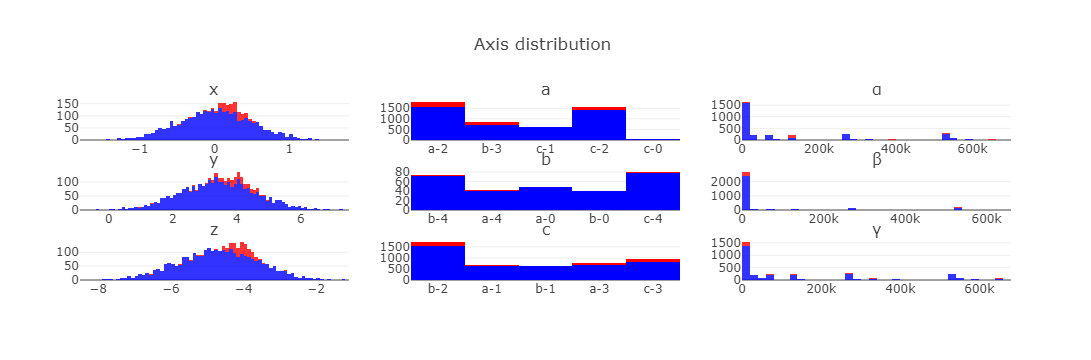

In [37]:
df_name = ""
plot_axis_all(df_read, df_ColGroup_pc1, df_cus)

In [ ]:
plot_comparsion_all(df_cus)

## <span style='color:DarkOliveGreen'>PCA column group check<span style='color:DarkOliveGreen'>

In [117]:
bool_plot = True
dict_df = {}
# sep, feat = [s*n_per_col for s in range(0, 4)], [chr(c) for c in range(97, 100)]
select_seq, select_sort, select_encode = cal_list_sum, sort_LargeToSmall, encode_category

In [118]:
feat =['α','β','γ']
sep,sum_ = [0],0
for s in pca_cg['n_cols']:
    sum_ += s
    sep.append(sum_)  

### (1). PC-F

In [182]:
%%capture
# df_binary = df_bin_pcaFA.copy()
select_group = "PCA_Font_Abs"
df_binary = df_bin_pca_FA.copy()
df_pcaFA = perform_encoding(df_binary, select_seq, select_encode, select_sort, sep_list = sep, new_col_name = feat)
if bool_plot: plot_comparsion_all(df_read, df_binary,df_pcaFA, d_select=d_select_FA, sep = sep, pca= pca) 


select_group = "PCA_Font_WT."
df_binary = df_bin_pca_FW.copy()
df_pcaFW = perform_encoding(df_binary, select_seq, select_encode, select_sort, sep_list = sep, new_col_name = feat)
if bool_plot: plot_comparsion_all(df_read,df_binary ,df_pcaFW, d_select=d_select_FW, sep = sep, pca= pca) 

### (2). PC-B

In [36]:
%%capture
df_binary = df_bin_pc_Ba.copy()
select_group = f"PC_B_abs"
df_pc_b_a = perform_encoding(df_binary.copy(), select_seq, select_encode, select_sort, sep_list = sep, new_col_name = feat)
if bool_plot: plot_comparsion_all(df_pc_b_a, sep = sep) 

df_binary = df_bin_pc_B.copy()
select_group = f"PC_B"
df_pc_b = perform_encoding(df_binary.copy(), select_seq, select_encode, select_sort, sep_list = sep, new_col_name = feat)
if bool_plot: plot_comparsion_all(df_pc_b, sep = sep) 

### (4). RND

In [40]:
%%capture
df_binary = df_br.copy()
select_seq, select_sort, select_encode = cal_list_Rnd, sort_LargeToSmall, encode_category
select_group = "RND"
df_rnd = perform_encoding(df_binary.copy(), select_seq, select_encode, select_sort, sep_list = sep, new_col_name = feat)
if bool_plot: plot_comparsion_all(df_rnd) 


### (5). RND col drop

In [88]:
random.seed(1224)
randomlist = random.sample(range(0,3*sliced_part), 3*sliced_part - (n_per_col*n_pc))
df_rnd_drop = df_bin.copy().drop(df_bin.columns[randomlist], axis=1)

In [89]:
%%capture
select_group = "xyz"
df_binary = df_rnd_drop.copy()

select_seq, select_sort, select_encode = cal_list_Rnd, sort_LargeToSmall, encode_category
df_rnd_col_drop = perform_encoding(df_binary.copy(), select_seq, select_encode, select_sort)
if bool_plot: plot_comparsion_all(df_rnd_col_drop) 

KeyboardInterrupt: 

### save all df

In [864]:
# save dfs to dict_df
dict_df = {
    "Original Cont.":df_r,
    "Bianry":df_bin,
    # "Bin_PC_F":df_pc_f,
    # "Bin_PC_B":df_pc_b,
    "PC_F abs":df_pc_f_a,
    "PC_F":df_pc_f,
    
    "PC_B abs":df_pc_b_a,
    "PC_B":df_pc_b,
    # f"PC {3*sliced_part}":df_pcl1_encode,   
    
    "Rnd":df_rnd,
    # "Rnd_Col drop":df_rnd_col_drop,
}

In [865]:
for df in dict_df:
    print(df, dict_df[df].drop_duplicates().shape)

Original Cont. (3300, 4)
Bianry (3087, 166)
PC_F abs (3087, 4)
PC_F (3087, 4)
PC_B abs (3087, 4)
PC_B (3087, 4)
Rnd (3087, 4)


## <span style='color:purple'>GA<span style='color:DarkOliveGreen'>

### &emsp;&emsp; * <span style='color:white'>fun<span style='color:white'>

####  &emsp;  &emsp; -GA

#####  &emsp;  &emsp;  &emsp; &emsp;  --record, crossover, mutation

In [160]:
### record 
def on_generation(ga):
    print("Generation", ga.generations_completed)
    print(ga.population)
    
def on_fitness(ga, population_fitness):
    avg = sum(ga.last_generation_fitness)/len(ga.last_generation_fitness)
    maximul = max(ga.last_generation_fitness)
    ft_iteration_avg.append(avg)
    ft_iteration_best.append(maximul)
    if ft_so_far_the_best:
        if max(ft_so_far_the_best)<=maximul:ft_so_far_the_best.append(maximul)
        else:ft_so_far_the_best.append(ft_so_far_the_best[-1])
    else:ft_so_far_the_best.append(maximul)
    
### crossover
def order_crossover(parents, offspring_size, ga_instance):
    offspring = []
    idx = 0
    while len(offspring) != offspring_size[0]:
        p1 = list(parents[idx % parents.shape[0], :].copy())
        p2 = list(parents[(idx + 1) % parents.shape[0], :].copy())
        
        cut_pt = sorted(sample(p1,2))
        p1_ele = [p1[e] for e in range(cut_pt[0],cut_pt[1]+1)]
        p2_ele = [p for p in p2 if p not in p1_ele]

        offspring.append(p2_ele[0:cut_pt[0]]+p1_ele+p2_ele[cut_pt[0]:])
        idx += 1
    return np.array(offspring)

def position_based_crossover(parents, offspring_size, ga_instance):
    offspring = []
    idx = 0
    while len(offspring) != offspring_size[0]:
        p1 = list(parents[idx % parents.shape[0], :].copy())
        p2 = list(parents[(idx + 1) % parents.shape[0], :].copy())
        
        cut_pts = sorted(sample(p1,sample(p1,1)[0]))
        p1_ele = [p1[e] for e in cut_pts]
        p2_ele = [p for p in p2 if p not in p1_ele]
        
        c,e=[],0
        for i in cut_pts:
            c,e = p2_ele.insert(i,p1_ele[e]),e+1
            
        offspring.append(p2_ele)
        idx += 1

    return np.array(offspring)

### mutation
def swap_mutation(offspring, ga_instance):
    for chromosome_idx in range(offspring.shape[0]):
        c = list(offspring[chromosome_idx])
        mut_pt = sorted(sample(c,2))
        c[mut_pt[0]], c[mut_pt[1]] = c[mut_pt[1]], c[mut_pt[0]]
        offspring[chromosome_idx] = np.array(c)
    return offspring

def scramble_mutation(offspring, ga_instance):
    for chromosome_idx in range(offspring.shape[0]):
        c = list(offspring[chromosome_idx])
        cut_pt = sorted(sample(c,2))
        scrable_ele = c[cut_pt[0]:cut_pt[1]+1]
        offspring[chromosome_idx] = np.array(c[0:cut_pt[0]]+sample(scrable_ele,len(scrable_ele))+c[cut_pt[1]+1:])
    return offspring

#####  &emsp;  &emsp;  &emsp; &emsp;  --fittness

In [161]:
gd_fit.sep

[0, 9, 18, 27]

In [162]:
# fittness
def min_type1_dis_fitness(solution, solution_idx): # need df_1 and l_col
    # ori_data = ori_data
    df = gd_fit.df_group
    sep = gd_fit.sep
    n_oreder = [df.columns[:-1].tolist()[i] for i in solution]
    df_order,n_data,total_mse = df.loc[df.GB==1].copy()[n_oreder], [], 0
    for r in range(0,len(df_order)):
        n_r = []
        for i, s in enumerate (sep[:-1]): n_r.append(encode_category(df_order.iloc[r,s:sep[i+1]]))
        n_data.append(n_r)    
    df_encode = pd.DataFrame(n_data)
    
    for c in df_encode.columns:
        l = list(df_encode[c])
        total_mse += -mean_squared_error(l, [sum(l)/len(l)]*len(l))
    return total_mse

def max_ssb_ssw_fitness(solution, solution_idx):
    # ori_data = ori_data
    df = gdf.df_bin
    n_oreder = [df.columns[:-1].tolist()[i] for i in solution]
    df_order_0, df_order_1 = df.loc[df.GB==0].copy()[n_oreder], df.loc[df.GB==1].copy()[n_oreder]    
    X,Y,total_error = [],[],0
    for r in range(0,len(df_order_0)):
        n_r = []
        for i, s in enumerate (gdf.sep[:-1]): n_r.append(encode_category(df_order_0.iloc[r,s:ds.sep[i+1]]))
        X.append(n_r) 
    for r in range(0,len(df_order_1)):
        n_r = []
        for i, s in enumerate (gdf.sep[:-1]): n_r.append(encode_category(df_1_new.iloc[r,s:ds.sep[i+1]]))
        Y.append(n_r)
        
    df_encode_0, df_encode_1 = pd.DataFrame(X),pd.DataFrame(Y)  
    for c in df_new_encode.columns:
        X,Y = list(df_encode_0[c]),list(df_encode_1[c])
        SST, SSE = sum([(t - np.mean(X+Y))**2 for t in X+Y]), sum([(x - np.mean(X))**2 for x in X])+sum([(y - np.mean(Y))**2 for y in Y])
        total_error += (SST-SSE) # += SSB
    return total_error

####  &emsp;  &emsp; -plot

In [163]:
def plot_GA_evolve(ft_iteration_best,ft_so_far_the_best,ft_iteration_avg):
    # Create traces
    x = [i for i in range(1,num_generations+1)]
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=x, y=ft_iteration_best,mode='lines',name='iteration the best',marker_color='blue'))
    fig.add_trace(go.Scatter(x=x, y=ft_so_far_the_best,mode='lines',name='so far the best',marker_color='red'))
    fig.add_trace(go.Scatter(x=x, y=ft_iteration_avg,mode='lines', name='iteration average',marker_color='green'))
    fig.update_layout(title="Binary column permutation",xaxis_title="Generation",yaxis_title="Fitness",
                      legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1))
    return fig

In [164]:
def arrange_col_by_order(df_bin, order):
    n_data = []
    n_oreder = list(order)
    df_new = df_bin.copy()[n_oreder]
    for r in range(0,len(df_bin)):
        n_data.append(encode_category(df_new.iloc[r,:]))
    df_new = pd.DataFrame(n_data)
    df_new["GB"] = df_bin.GB
    return df_new

def get_cumulated_points(df):
    ordered_dict = collections.OrderedDict(sorted(Counter(df[0]).items()))
    x,y = [],[]
    cum = 0
    for c in ordered_dict:
        cum+=ordered_dict[c]
        x.append(c)
        y.append(cum)
    new_y = []
    for o in y:
        if o and max(y)!=0: new_y.append(o/max(y))
        else:new_y.append(0)
    return x,new_y

def plot_encode_axis(df, name):
    fig = make_subplots(rows=2, cols=1, shared_xaxes='all')#, column_widths=[0.7, 0.3])
    df_1 = df.loc[df.GB==1]
    df_0 = df.loc[df.GB==0]
    x1,y1 = get_cumulated_points(df_1)
    x0,y0 = get_cumulated_points(df_0)
    fig.add_trace(go.Scatter(x=df_0[0],y=len(df_0)*[f"GB=0"],
        mode='markers',marker_color='blue',name=f"GB=0, [{len(df_0)}]",),row=1, col=1)

    fig.add_trace(go.Scatter(x=df_1[0],y=len(df_1)*["GB=1"],
        mode='markers',marker_color='red',name=f"GB=1, [{len(df_1)}]",),row=1, col=1)
    
    fig.add_trace(go.Scatter(x=x1, y=y1,mode='lines',marker_color='red',name='cum 1'),row=2, col=1)
    fig.add_trace(go.Scatter(x=x0, y=y0,mode='lines',marker_color='blue',name='cum 2'),row=2, col=1)
    
    for trace in fig['data']: 
        if("cum" in trace['name']): trace['showlegend'] = False
    fig.update_layout(title=f"Encoding result, {name}",xaxis2_title="Categorical variable",#yaxis_title="Type",
                      legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1))
    return fig

####  &emsp;  &emsp; -Class

In [165]:
class GA_encoder(seq_encoder):
    # 建構式
    def __init__(self,Grouped_Data, name):
        self.name = name
        self.gd = Grouped_Data
        self.df_group = Grouped_Data.df_group.copy()
        self.df_group_ori = Grouped_Data.df_group_ori
        self.sep = self.gd.sep
    # 方法(Method)
    def bulid_ga(self, sol_per_pop = 10, num_generations = 30,parent_selection_type = "sss",
                 crossover_probability=0.8,mutation_probability = 0.2,fitness_func=min_type1_dis_fitness):
        # get gene space 
        gene_space,s = [],[]
        for i in range(0, self.sep[-1]+1):
            s.append(i)
            if i+1 in self.sep:
                [gene_space.append(s) for _ in range(0,len(s))]
                s = []
        num_genes = len(self.df_group.columns[:-1])
        # ga settings
        ga_instance = pygad.GA(
            num_generations=num_generations,
            sol_per_pop=sol_per_pop,
            num_genes=num_genes,
            init_range_low=0,
            init_range_high=num_genes,

            parent_selection_type=parent_selection_type,

            # crossover_type=crossover_type,
            crossover_probability=crossover_probability,

            # mutation_type=mutation_type,
            mutation_probability = mutation_probability,

            num_parents_mating=2,
            fitness_func=fitness_func,

            gene_type=int,
            gene_space=gene_space,
            # on_generation = self.on_generation,
            on_fitness = on_fitness,
            allow_duplicate_genes=False,
            )
        self.ga = ga_instance
        self.best_sol = [self.df_group.columns[:-1].tolist()[i] for i in list(self.ga.best_solution()[0])]
        
    def run_ga(self):
        self.ga.run()
        # return self.ga.plot_result()
    
    def set_evole_record(self, ft_iteration_avg, ft_iteration_best,ft_so_far_the_best):
        self.ft_iteration_avg = ft_iteration_avg
        self.ft_iteration_best = ft_iteration_best
        self.ft_so_far_the_best = ft_so_far_the_best
        
    def plot_evole(self):
        # Create traces
        x = [i for i in range(1,self.ga.num_generations+1)]
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=x, y=self.ft_iteration_best,
                            mode='lines',name='iteration the best',marker_color='blue'))
        fig.add_trace(go.Scatter(x=x, y=self.ft_so_far_the_best,
                            mode='lines',name='so far the best',marker_color='red'))
        fig.add_trace(go.Scatter(x=x, y=self.ft_iteration_avg,
                            mode='lines', name='iteration average',marker_color='green'))
        fig.update_layout(title="Binary column permutation",xaxis_title="Generation",yaxis_title="Fitness",
                          legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1))
        return fig
    def encode_categorical(self):
        n_oreder, new_data = self.best_sol,[]
        df_swap = self.df_group.copy()[n_oreder]
        for r in df_swap.T:
            row_data = []
            l = self.sep[0]
            for i in self.sep[1:]:
                row_data.append(encode_category(df_swap.iloc[r,l:i]))
                l = i
            new_data.append(row_data)
        df_new = pd.DataFrame(new_data)
        df_new.columns = [self.df_group.columns[i].split('-')[0] for i in self.sep[:-1]]
        df_new["GB"] = self.df_group.GB
        self.df_encode_cate = df_new
        return df_new

### &emsp;| (1) build GA model

In [132]:
# Dataframe para
# df = ds_bin_xyz.df

gd_fit  = gd_xyz
ft_iteration_avg, ft_iteration_best, ft_so_far_the_best=[],[],[]

In [133]:
ga_xyz = GA_encoder(ds,"GA")

In [134]:
ga_xyz.bulid_ga(sol_per_pop=10, num_generations=50,)
ga_xyz.run_ga()

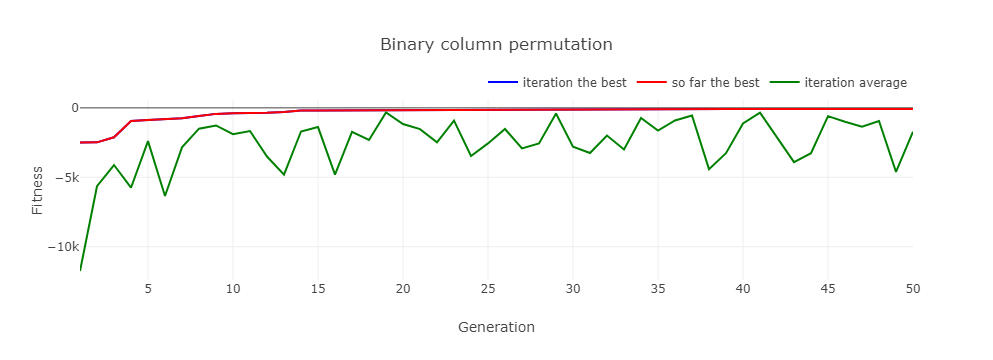

In [135]:
ga_xyz.set_evole_record(ft_iteration_avg,ft_iteration_best,ft_so_far_the_best)
ga_xyz.plot_evole()

In [136]:
fig.write_html(r"C:\Users\User\Desktop\Terry\Data\Output\3D Fig\GA evovle.html")

In [137]:
sol = [i for i in range(0,len(ds.df_bin.columns[:-1]))]
sol

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26]

In [102]:
min_type1_dis_fitness(sol,_)

-28.47599020145188

In [113]:
max_ssb_ssw_fitness(sol,_)

4662.841899992229

In [109]:
total_error = 0
for c in df_new_encode.columns:
    X,Y = list(df_0_new_encode[c]),list(df_1_new_encode[c])
    SST, SSE = sum([(t - np.mean(X+Y))**2 for t in X+Y]), sum([(x - np.mean(X))**2 for x in X])+sum([(y - np.mean(Y))**2 for y in Y])
    SSB = SST-SSE
    total_error += SSB
return total_error

### &emsp;| (2) encoding result

In [396]:
ga_xyz.encode_categorical()

,z,y,x,GB
0,1,2,1,0
1,2,2,1,0
2,1,2,1,0
3,2,2,1,0
4,2,2,1,0
...,...,...,...,...
3295,1,2,1,1
3296,1,2,1,1
3297,1,2,1,1
3298,1,2,1,1


In [397]:
out_put_path = r"C:\Users\User\Desktop\Terry\Data\Output"
plot_comparsion_all_new(df_read, df_bin, ga_xyz.encode_categorical(), dr_name = "GA",sep=ga_xyz.Dataset.sep)

<_io.TextIOWrapper name="C:\\Users\\User\\Desktop\\Terry\\Data\\Output/['GA'].html" mode='a' encoding='cp1252'>

In [407]:
plot_compare_all(ds_data, ga_xyz, dr_name = "GA")

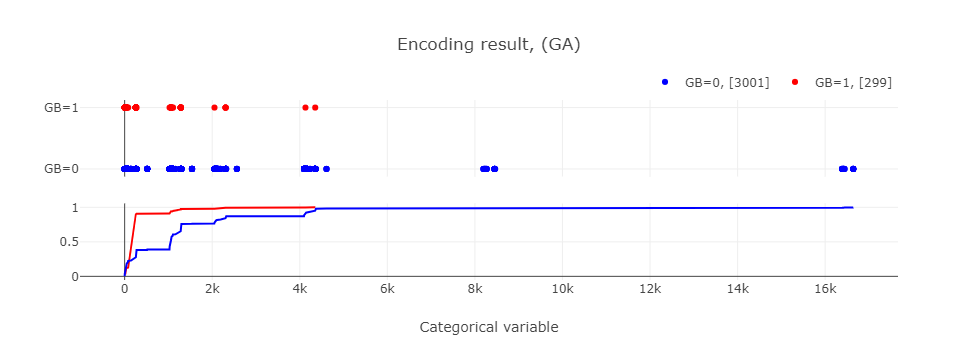

In [379]:
df_ga = arrange_col_by_order(df_bin,[l_col[i] for i in list(ga_xyz.ga.best_solution()[0])])
plot_encode_axis(df_ga, "(GA)")

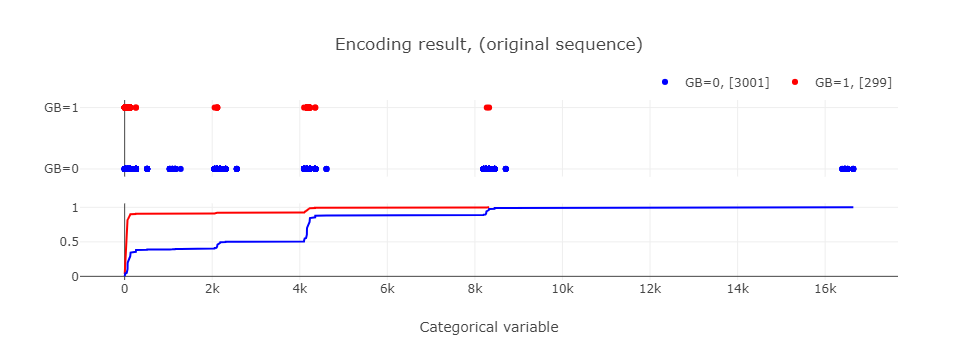

In [378]:
df_ori = arrange_col_by_order(df_bin,df_bin.columns[:-1])
plot_encode_axis(df_ori, "(original sequence)")# df_new

## <span style='color:brown'>Defult class<span style='color:brown'>

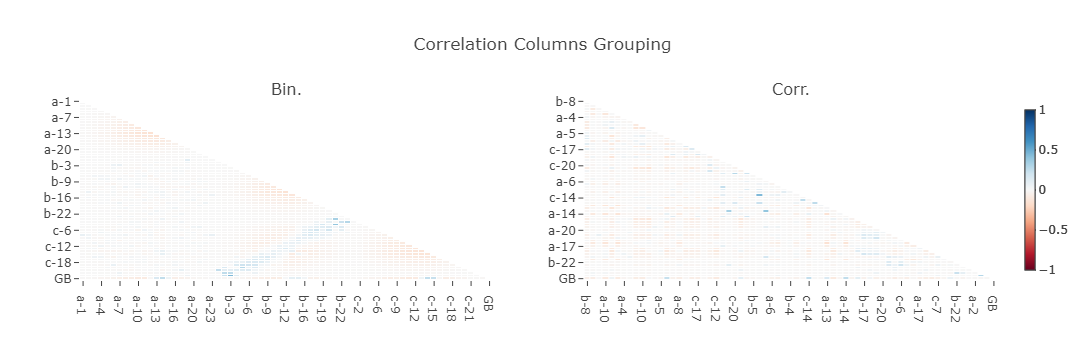

In [95]:
plot_corr_column_grouping(gd_corr)

In [55]:
def plot_encode_axis(encoder):
    fig = make_subplots(rows=2, cols=2, shared_xaxes='columns')#, column_widths=[0.7, 0.3])
    df_c,df_g = encoder.encode_categorical(),encoder.rerange_grid()
    for i, tp in enumerate( [df_c,df_g]):
        df = tp
        df_1 = df.loc[df.GB==1]
        df_0 = df.loc[df.GB==0]
        x1,y1 = get_cumulated_points(df_1)
        x0,y0 = get_cumulated_points(df_0)

        fig.add_trace(go.Scatter(x=df_0[df.columns[0]],y=len(df_0)*[f"GB=0"],mode='markers', marker=dict(color="blue"),
                                 name=f"GB=0, [{len(df_0)}]",),row=1, col=i+1)
        fig.add_trace(go.Scatter(x=df_1[df.columns[0]],y=len(df_1)*["GB=1"],mode='markers', marker=dict(color="red"),
                                 name=f"GB=1, [{len(df_1)}]",),row=1, col=i+1)

        fig.add_trace(go.Scatter(x=x1, y=y1,mode='lines',marker_color='red',name='cum 1')
                      ,row=2, col=i+1)
        fig.add_trace(go.Scatter(x=x0, y=y0,mode='lines',marker_color='blue',name='cum 2')
                      ,row=2, col=i+1)

        for trace in fig['data']: trace['showlegend'] = False
            # if("cum" in trace['name']): trace['showlegend'] = False
    fig.update_layout(title=f"Rearrange comparison",xaxis3_title="Categorical",xaxis4_title="Rearrange-grid",)#yaxis_title="Type",)
                      # legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1))
    return fig

In [56]:
def overlap_transform(X_train,y_train):
    X_train,y_train =x,y
    df, col_name, = X_train.copy(), y_train.copy().columns[-1]
    df[col_name]= y_train.copy()
    df_type1 = df.loc[df[col_name] == 1].drop_duplicates().drop(columns=[col_name],)
    new_y_train,l = [],[list(row) for row in df_type1.values]
    for row in X_train.values:
        if list(row) in l:new_y_train.append(1)
        else: new_y_train.append(0)
    return pd.DataFrame(data=new_y_train, columns=[col_name], index = y_train.index)

### (1). rnd

In [146]:
rnd_encoder = seq_encoder(gd_rnd, "rnd")
rnd_encoder.set_encode_funs(seq_rnd,sort_LargeToSmall,encode_category)
# rnd_encoder.encode_categorical()

In [147]:
plot_encode_axis(rnd_encoder)

TypeError: plot_encode_axis() missing 1 required positional argument: 'name'

### (2). sum

In [152]:
sum_encoder = seq_encoder(gd_rnd, "sum")
sum_encoder.set_encode_funs(seq_sum,sort_LargeToSmall,encode_category)
# sum_encoder.encode_categorical()

In [191]:
sum_encoder.encode_categorical()

,b,c,b,GB
0,320,0,0,0
1,192,0,16,0
2,64,0,256,0
3,64,0,16,0
4,0,256,16,0
...,...,...,...,...
3295,384,256,0,1
3296,384,0,0,1
3297,256,256,256,1
3298,384,256,0,1


In [188]:
# df = sum_encoder.encode_grid()
for r in df.columns[:-1]:
    print(r)
    tar = sorted(df[r].unique())
    aim = [i for i in range(0,len(tar))]

pc1
pc2
pc3


In [75]:
out_put_path = r"C:\Users\User\Desktop\Terry\Data\Output\3D Fig"
plot_compare_all(ori_data,sum_encoder,sum_encoder.encode_grid(),sum_encoder.reindex_encoded())

"C:\\Users\\User\\Desktop\\Terry\\Data\\Output\\3D Fig/['66', 'sum'].html"

In [519]:
fig = plot_encode_axis(sum_encoder)
fig.write_html(r"C:\Users\User\Desktop\Terry\Data\Output\3D Fig\rearrange comparison.html")

AttributeError: 'seq_encoder' object has no attribute 'rerange_grid'

### (3). ground truth

In [156]:
gt_encoder = seq_encoder(gd_xyz, "ID")
gt_encoder.set_encode_funs(seq_ID,sort_SmallToLarge,encode_category)
# gt_encoder.encode_categorical()

In [157]:
plot_compare_all(ori_data,gt_encoder,gt_encoder.encode_grid(),gt_encoder.reindex_encoded())

"C:\\Users\\User\\Desktop\\Terry\\Data\\Output\\3D Fig\\shape 1\\Bin_Feat - 30 (27)/['27', 'ID'].html"

In [142]:
plot_bin_axis(ori_data, gt_encoder, gt_encoder.encode_grid())

AttributeError: 'seq_encoder' object has no attribute 'df_encode_cate'

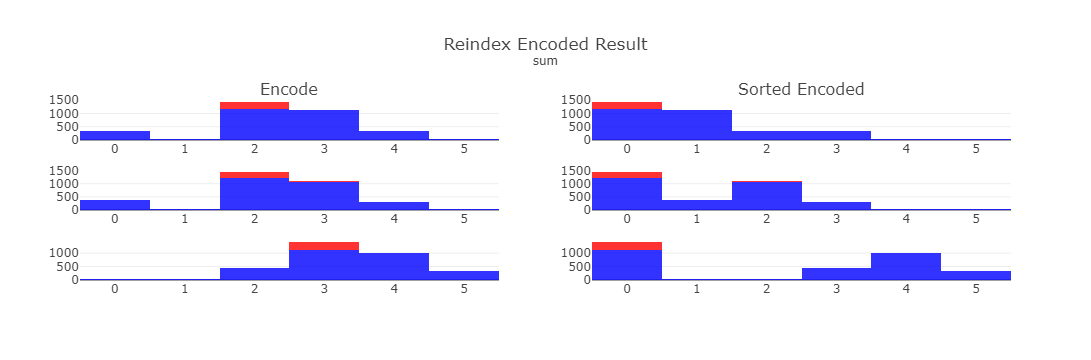

In [984]:
plot_encode_axis(sum_encoder, gt_encoder.encode_grid(), gt_encoder.reindex_encoded())

### (4). Gini value

In [719]:
gi_encoder = seq_encoder(gd_bin_xyz,"gini")
gi_encoder.set_encode_funs(seq_ratio,sort_LargeToSmall,encode_category)
# gi_encoder.encode_categorical()

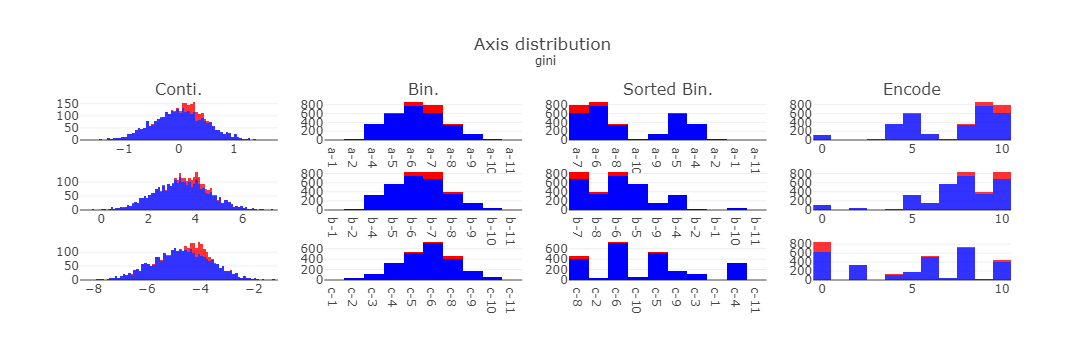

In [720]:
plot_axis_new(ori_data, gi_encoder, gi_encoder.encode_grid())

In [528]:
shp_name = "test"
out_put_path = r"C:\Users\User\Desktop\Terry\Data\Output\3D Fig"
plot_compare_all(ori_data,gi_encoder,gi_encoder.encode_grid())

"C:\\Users\\User\\Desktop\\Terry\\Data\\Output\\3D Fig/['30', 'gini'].html"

# **4. Classification results**
---

### functions

In [261]:
from sklearn.model_selection import train_test_split
from ipywidgets import Layout
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os

#### -ui

In [262]:
### UI event
gbm_metric = "average_precision"
gbm_boost_type = "gbdt"
gbm_feval = True
gbm_round = 500
def rb_event_gbm_metric(sender):
    global gbm_metric   
    gbm_metric = rb_gbm_metric.value
def rb_event_gbm_boost_type(sender):
    global gbm_boost_type   
    gbm_boost_type = rb_gbm_boost_type.value  
def rb_event_gbm_feval(sender):
    global gbm_feval   
    tp = rb_gbm_feval.value
    if tp == "on":
        gbm_feval = True
    elif tp == "off":
        gbm_feval = False

In [263]:
### UI outlook
rb_gbm_boost_type = widgets.RadioButtons(
    options=["gbdt", "dart", "rf","goss"],
    layout={'width': 'max-content'},
)
rb_gbm_metric = widgets.RadioButtons(
    options=["average_precision", "auc", "rmse","binary_logloss","None"],
    layout={'width': 'max-content'},
)
rb_gbm_feval = widgets.RadioButtons(
    options=["on", "off"],
    layout={'width': 'max-content'},
)
sd_gbm_fbeta = widgets.FloatSlider(value = 0.5, min = 0.0, max = 1.0, step = 0.1,description='',layout=Layout(width='200px'))
sd_gbm_round = widgets.IntSlider(value = 500, min = 100, max = 10000, step = 100,description='',layout=Layout(width='300px'))
rb_gbm_boost_type.observe(rb_event_gbm_boost_type, names=['value'])
rb_gbm_metric.observe(rb_event_gbm_metric, names=['value'])
rb_gbm_feval.observe(rb_event_gbm_feval, names=['value'])

#### -feval functions

In [264]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score

feval_fun = None
def lgb_fbeta_score(y_hat, data):
    beta_value=sd_gbm_fbeta.value
    y_true = data.get_label()
    y_hat = np.where(y_hat < 0.5, 0, 1)   # scikits f1 doesn't like probabilities
    return f'f {beta_value} ', fbeta_score(y_true, y_hat, beta = beta_value), True

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.where(y_hat < 0.5, 0, 1)   # scikits f1 doesn't like probabilities
    return 'f 1 ', f1_score(y_true, y_hat), True

#### -classification

In [290]:
def matrix_reflection(m):
    tl,tr = m[0][0], m[1][0]
    dl,dr = m[0][1],m[1][1]
    n = np.array([[dr, dl],[tr, tl]])
    return n

def recall_precision_n(m):
    tp,fp = m[0][0], m[1][0]
    fn,tn = m[0][1],m[1][1]
    a = (tp+tn)/(tp+fp+fn+tn)
    p = np.sum(tp / (tp + fn))
    r = np.sum(tp / (tp + fp))
    f = (2 * p * r) / (r + p)
    return  dict(recall = r, precision = p, f1_score = f)

In [273]:
def overlap_transform(X_train,y_train):
    # X_train,y_train =x,y
    df, col_name, = X_train.copy(), y_train.copy().columns[-1]
    df[col_name]= y_train.copy()
    df_type1 = df.loc[df[col_name] == 1].drop_duplicates().drop(columns=[col_name],)
    new_y_train,l = [],[list(row) for row in df_type1.values]
    for row in X_train.values:
        if list(row) in l:new_y_train.append(1)
        else: new_y_train.append(0)
    return pd.DataFrame(data=new_y_train, columns=[col_name], index = y_train.index)

In [288]:
def cal_all_dfs(dict_datasets):
    dict_cm,dict_eval,dict_clf = {},{},{}
    df_all = pd.DataFrame()
    for name_df in dict_datasets:
        s, dict_cm[name_df], dict_eval[name_df], dict_clf[name_df] = pre_and_cal_score(dict_datasets[name_df])
        df_m = pd.DataFrame.from_dict(s, orient='index')
        df_m.columns = [name_df]
        df_all = pd.concat([df_all, df_m], axis=1)
    return df_all, dict_clf, dict_eval, dict_cm

def pre_and_cal_score(df): 
    df = df.copy()
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1:]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1224, train_size = .75,stratify=y,)
    # overlap trasform
    y_train = overlap_transform(X_train,y_train)
    cm, evals_result, clf = light_gbm(X_train, X_test, y_train, y_test)
    cm_r = matrix_reflection(cm)
    # cm_r = cm
    return recall_precision_n(cm_r), cm_r, evals_result, clf

def light_gbm(X_train, X_test, y_train, y_test):
    lgb_train = lgb.Dataset(data=X_train,label=y_train)
    lgb_test = lgb.Dataset(data=X_test,label=y_test)

    evals_result = {} 
    clf = lgb.train(
        params = params,
        train_set = lgb_train, 
        num_boost_round = gbm_round,
        valid_sets = [lgb_train, lgb_test], 
        valid_names = ["Train", "Validation"], 
        evals_result = evals_result, 
        early_stopping_rounds = None,
        feval=feval_fun,
    )
    # prediction on test data
    y_pred_lgbm = clf.predict(X_test, num_iteration = clf.best_iteration)
    # convert into binary values
    for i in range(0, X_test.shape[0]):
        if y_pred_lgbm[i] > .5:y_pred_lgbm[i] = 1
        else:y_pred_lgbm[i] = 0
    # output confusion matris
    cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
    return cm_lgbm, evals_result, clf



#### -plot

In [268]:
def plot_heatmap_all(dict_cm):
    fig,ax=plt.subplots(1,len(dict_cm),figsize=(5*len(dict_cm), 5))

    # target = ['Ori','Mach','Mach_LS','Mach_SL','Cham','Cham_LS','Cham_SL']
    tick = ["GB=1","GB=0"]
    # for index, i in enumerate(target):
    x = 0
    for i in dict_cm:
        cm = dict_cm[i]
        sns.set(font_scale=1.8)
        sns.heatmap(cm, annot = True,xticklabels=tick,yticklabels=tick, fmt="", cbar=False,ax = ax[x])
        #, rc={'axes.facecolor':color, 'figure.facecolor':color} )
        ax[x].set_title(i)
        ax[x].get_xaxis().set_visible(True)
        if x != 0:
            ax[x].get_yaxis().set_visible(False)
        x = x+1
    p = [n for n in df_name.split('/')]
    plt.suptitle(f"{p[0]}, {p[1]}", fontsize=30, y = 1.1)
    return fig
    
def plot_learning_curve_all(dict_eval, metric=None):
    fig,ax=plt.subplots(1,len(dict_eval),figsize=(5*len(dict_eval), 5))
    # for index, i in enumerate(target):
    x = 0
    for i in dict_eval:
        lgb.plot_metric(dict_eval[i], title = i, ax = ax[x], metric = metric)
        ax[x].get_legend().remove()
        x = x+1
    x = 0
    lines = []
    labels = []
    axLine, axLabel = ax[0].get_legend_handles_labels()
    lines.extend(axLine)
    labels.extend(axLabel)   
    fig.legend(lines, labels, loc = "upper left", ncol=len(dict_eval))
    fig.tight_layout()
    p = [n for n in df_name.split('/')]
    plt.suptitle(f"{p[0]}, {p[1]}", fontsize=30, y = 1.1)
    return fig

In [269]:
def plot_class_score(df_data):
    global df_name
    df_name = f"{shp_name} / Binary Features: {n_bin_col}"
    df = df_data.T.copy()
    fig = go.Figure()
    
    for col in df.columns:
        fig.add_trace(go.Bar(x=df.index,y=df[col],name=col,opacity=0.8))
    fig.update_layout(
        title_text=f'LightGBM Classification result <br><sup> {df_name} </sup> ', # title of plot
        yaxis_title_text='score', # yaxis label
        barmode='group',
        legend_tracegroupgap = 180,
        bargap=0.3, # gap between bars of adjacent location coordinates
        bargroupgap=0.1, # gap between bars of the same location coordinates      
        height=500,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )
    
    return fig

def plot_class_cm(dict_cm):
    fig = make_subplots(rows=1, cols=len(dict_cm),subplot_titles=(list(dict_cm.keys())))
    for i in range(0,len(dict_cm)):
        cm = dict_cm[list(dict_cm.keys())[i]]
        heatmap = go.Heatmap(x = ["GB = 1","GB = 0"],y = ["GB = 1","GB = 0"], z = cm, 
                             text=cm, texttemplate="%{text}",textfont={"size":10},
                             showscale=False,xgap=3, ygap=3,colorscale='RdBu')
        fig.add_trace(heatmap,row=1, col=i+1)

    fig.update_yaxes(showgrid=False,showticklabels=False,autorange='reversed')
    fig['layout']['yaxis'].update(showgrid=False,showticklabels=True,autorange='reversed')
    fig.update_xaxes(showgrid=False,showticklabels=True)    
    fig.update_layout(title = "Confusion Matrix", showlegend=True,height=300,
                      # margin=go.layout.Margin(t=30,)
                     )
    return fig

def plot_class_score_table(df_data):
    # df = df_data.copy().applymap(lambda x: str(int(x)) if abs(x - int(x)) < 1e-6 else str(round(x,3)))
    df = df_data.copy()
    s_color = ['blue', 'orange', 'green']
    fig = go.Figure(data=[go.Table(ids=df.index,
    header=dict(values = df.columns.tolist()
                ,fill_color='cornflowerblue',align='center',
                font=dict(color='white',size=15)),
    cells=dict(values = [df[c].values for c in df.columns]
               ,fill_color='ivory',align='center'
               ,font=dict(size=12, color = [s_color*len(df.columns)])))])
    fig.update_layout(height = 130,
                      margin=go.layout.Margin(t=0, b=0)
                      )
    return fig

def plot_class_all(df_all, dict_cm, bc):
    global n_bin_col
    n_bin_col = bc-3
    fig_sc = plot_class_score(df_all.copy())
    fig_cm = plot_class_cm(dict_cm.copy())
    fig_tb = plot_class_score_table(df_all.copy())
    # output fig, create path if not exist
    if not os.path.exists(out_put_path): os.makedirs(out_put_path)
    # check output name, delete file if exist
    p = [f"{n_bin_col}","Classification results"]
    if os.path.exists(f"{out_put_path}/{p}.html"): os.remove(f"{out_put_path}/{p}.html")
    # df_name = f"{shp_name} / SP {sliced_part} / {select_group} /{m_name}"
    with open(f"{out_put_path}/{p}.html", 'a') as f:
        f.write(fig_sc.to_html(full_html=False, include_plotlyjs='cdn'))
        f.write(fig_tb.to_html(full_html=False, include_plotlyjs='cdn'))
        f.write(fig_cm.to_html(full_html=False, include_plotlyjs='cdn'))

## i. params settings

In [270]:
vb_metiric = VBox([Button(description="metric"), rb_gbm_metric])
vb_boost_type = VBox([Button(description="boost type"), rb_gbm_boost_type])
vb_feval = VBox([Button(description="feval",layout=Layout(width='200px')), rb_gbm_feval,Button(description="beta",layout=Layout(width='200px')),sd_gbm_fbeta])
vb_boost_round=VBox([Button(description="boosting rounds",layout=Layout(width='300px')), sd_gbm_round])

display(HBox([vb_boost_type,vb_metiric, vb_feval,vb_boost_round]))

In [271]:
params = {
        "objective": "binary",
        "metric": gbm_metric,
        # "feval":lgb_fbeta_score,
        "verbosity": -1,
        "boosting_type": gbm_boost_type,                
        "seed": 1224,
    }
if gbm_feval: feval_fun = lgb_fbeta_score
gbm_round =  sd_gbm_round.value

## ii. classify by lightgbm

In [307]:
%%capture
df_all, dict_clf, dict_eval, dict_cm =  cal_all_dfs(dict_df)

In [308]:
df_all=df_all.fillna(0)
df_all = df_all.applymap(lambda x: str(int(x)) if abs(x - int(x)) < 1e-6 else str(round(x,3)))
df_all

,binary,original,GA
recall,0.72,0.72,0.72
precision,0.806,0.806,0.806
f1_score,0.761,0.761,0.761


In [273]:
out_put_path = rf"C:\Users\User\Desktop\Terry\Data\Output\3D Fig\{shp_name}\BC"
plot_class_all(df_all, dict_cm)

In [ ]:
df_name = f"{shp_name} / SP {sliced_part}"

if gbm_metric == "None": plot_learning_curve_all(dict_eval).show()
else: plot_learning_curve_all(dict_eval,gbm_metric).show()
plot_heatmap_all(dict_cm).show()

## * GA test*

In [306]:
# save dfs to dict_df
dict_df = {
    # "conti":df_read,
    "binary":df_bin,
    "original":df_ori,
    "GA":df_ga,
}

## * different BC test*

In [47]:
%%capture
# plot, & classify
shp_name = "shape 1"
d_sp_score = {}
R = range(9,153,3)
for bc in R:
    # 1. read -> slice -> drop cols 
    # read data (read data) ==> binary data (df_bin)
    df_read = read_df(shp_name)
    df_bin_s = slice_cont_to_bin(df_read,bc)
    # df_bin = drop_one_col_on_each_axis(df_bin_s)
    df_bin = df_bin_s
    n_bin_col, original_colList =len(df_bin.columns)-1, df_bin.columns
    out_put_path  = rf"C:\Users\User\Desktop\Terry\Data\Output\3D Fig\{shp_name}\BC {bc}-{n_bin_col}"
    # 2. group columns
    # group by pca, xyz, rnd
    pca, pca_cg = set_pca(df_bin,3)
    df_bin_rnd = group_col_rnd(df_bin,1224) # column group by rnd
    df_bin_pca_FA, d_pca_FA = group_col_pca(df_bin,"F", True, pca_cg)
    df_bin_pca_FW, d_pca_FW = group_col_pca(df_bin,"F", False, pca_cg)
    df_bin_pca_BA, d_pca_BA = group_col_pca(df_bin,"B", True, pca_cg)
    df_bin_pca_BW, d_pca_BW = group_col_pca(df_bin,"B", False, pca_cg)
    
    # 4. encoding
    sep, feat = generate_new_sep_and_feat(pca_cg['n_cols'])
    select_seq, select_sort, select_encode = cal_list_sum, sort_LargeToSmall, encode_category

    select_group = "RND"
    df_rnd = perform_encoding(df_bin_rnd.copy(), select_seq, select_encode, select_sort, sep,feat)
    plot_comparsion_all(df_read, df_bin_rnd, df_rnd, sep=sep)
    
    select_group = "XYZ"
    df_XYZ = perform_encoding(df_bin.copy(), select_seq, select_encode, select_sort)
    plot_comparsion_all(df_read, df_bin, df_XYZ, sep=sep)
    
    select_group = "PCA_Font_abs"
    df_pca_FA = perform_encoding(df_bin_pca_FA.copy(), select_seq, select_encode, select_sort, sep,feat)
    plot_comparsion_all(df_read, df_bin_pca_FA, df_pca_FA, sep=sep,d_select=d_pca_FA, pca = pca)
    
    select_group = "PCA_Font_weight"
    df_pca_FW = perform_encoding(df_bin_pca_FW.copy(), select_seq, select_encode, select_sort, sep,feat)
    plot_comparsion_all(df_read, df_bin_pca_FW, df_pca_FW, sep=sep,d_select=d_pca_FW, pca = pca)
    
    select_group = "PCA_Back_abs"
    df_pca_BA = perform_encoding(df_bin_pca_BA.copy(), select_seq, select_encode, select_sort, sep,feat)
    plot_comparsion_all(df_read, df_bin_pca_BA, df_pca_BA, sep=sep,d_select=d_pca_BA, pca = pca)
    
    select_group = "PCA_Back_weight"
    df_pca_BW  = perform_encoding(df_bin_pca_BW.copy(), select_seq, select_encode, select_sort, sep,feat)
    plot_comparsion_all(df_read, df_bin_pca_BW, df_pca_BW, sep=sep,d_select=d_pca_BW, pca = pca)
    
    # 4. Classification
    dict_df = {"Original Cont.":df_read,"Bianry":df_bin,"XYZ":df_XYZ,
               "PC Font abs":df_pca_FA,"PC Font weight":df_pca_FW,
               "PC Back abs":df_pca_BA,"PC Back weight":df_pca_BW,
               "Rnd":df_rnd,}
    df_all, dict_clf, dict_eval, dict_cm =  cal_all_dfs(dict_df)
    df_all=df_all.fillna(0)
    df_all = df_all.applymap(lambda x: str(int(x)) if abs(x - int(x)) < 1e-6 else str(round(x,3)))
    d_sp_score[f"bc {bc}"] = df_all.loc[["f1_score"]]
    
    plot_class_all(df_all, dict_cm)

In [48]:
%%capture
out_put_path = rf"C:\Users\User\Desktop\Terry\Data\Output\3D Fig\{shp_name}"
# output pca record
import openpyxl
d_df_abs = {}
d_df_wt = {}
for bc in R:
    df_read = read_df(shp_name)
    df_bin_s = slice_cont_to_bin(df_read,bc)
    df_bin = drop_one_col_on_each_axis(df_bin_s)
    n_bin_col, original_colList =len(df_bin.columns)-1, df_bin.columns
    pca, pca_cg = set_pca(df_bin,3)
    
    d_df_abs[f"BC {bc}"] = find_pca_selection_all(df_bin, True, pca_cg, "weight")
    d_df_wt[f"BC {bc}"] = find_pca_selection_all(df_bin, False, pca_cg, "weight")
    
# path = rf"C:\Users\User\Desktop\Terry\Data\Output\3D Fig\{shp_name}"
# writer_a = pd.ExcelWriter(rf'{path}\pca seq (abs).xlsx', engine='xlsxwriter')
# writer_w = pd.ExcelWriter(rf'{path}\pca seq (weight).xlsx', engine='xlsxwriter')
# for bc in d_df_abs:d_df_abs[bc].to_excel(writer_a,index = True, sheet_name=bc, header=None)
# for bc in d_df_wt:d_df_wt[bc].to_excel(writer_w,index = True, sheet_name=bc, header=None)
# writer_a.save()
# writer_w.save()
# writer_a.close()
# writer_w.close()

In [49]:
%%capture
# checking pca explained variance
d_pca_expvar = {}
for bc in R:
    df_read = read_df(shp_name)
    df_bin_s = slice_cont_to_bin(df_read,bc)
    df_bin = drop_one_col_on_each_axis(df_bin_s)
    n_bin_col, original_colList =len(df_bin.columns)-1, df_bin.columns
    pca, pca_cg = set_pca(df_bin,3)
    d_pca_expvar[f"BC-{bc}"] = ['%.1e' % elem for elem in pca.explained_variance_]
    # print()['%.1e' % elem for elem in pca.explained_variance_]
data = []
for bc in d_pca_expvar:
    # print([bc]+d_pca_expvar[bc])
    data.append([bc]+d_pca_expvar[bc])
df = pd.DataFrame(data)
df.columns = ["BC"]+[f"PC {i}" for i in range(1,len(df.T))]
df = df.set_index(["BC"])
df.to_excel(f"{out_put_path}\PCA explained variance.xlsx")  

In [46]:
# output class score
data = []
for bc in d_sp_score:
    xs = [bc]+[v for vs in d_sp_score[bc].values.tolist() for v in vs ]
    flat_list = [x for x in xs]
    data.append(flat_list)
df_class = pd.DataFrame(data)
df_class = df_class.set_index(keys=0)
df_class.columns = d_sp_score[bc].columns
df_class

,Original Cont.,Bianry,XYZ,PC Font abs,PC Font weight,PC Back abs,PC Back weight,Rnd
0,,,,,,,,
bc 9,0.725,0.687,0.687,0.687,0.687,0.687,0.687,0.687
bc 12,0.725,0.449,0.449,0.449,0.449,0.449,0.449,0.449
bc 15,0.725,0.681,0.681,0.681,0.681,0.681,0.681,0.681
bc 18,0.725,0.618,0.602,0.618,0.602,0.602,0.602,0.618
bc 21,0.725,0.662,0.662,0.657,0.657,0.662,0.662,0.662
bc 24,0.725,0.654,0.654,0.654,0.654,0.654,0.654,0.654
bc 27,0.725,0.704,0.725,0.719,0.725,0.725,0.725,0.725
bc 30,0.725,0.698,0.694,0.69,0.69,0.694,0.694,0.694
bc 33,0.725,0.696,0.692,0.692,0.701,0.696,0.688,0.688


## * different BC test* with GA

In [ ]:
%%capture
shp_name = "shape 1"
ori_data = Originl_Data(shp_name)

f1_score, re_score, pre_score = {},{},{}
R = range(30,103,3)
for bc in R:
    # 1. read and slice data
    #........................................................
    ori_data.slice_to_bin(bc)
    ori_data.drop_one_col()
    ori_data.drop_zero_col()
    ori_data.get_sep_and_col()
    out_put_path  = rf"C:\Users\User\Desktop\Terry\Data\Output\3D Fig\{shp_name}\Bin_Feat - {bc} ({ori_data.bin_feat})"
    
    # 2. group columns
    #........................................................
    ### xyz
    gd_xyz = Grouped_Data(ori_data,"xyz")
    gd_xyz.rearrange([i for i in range(0,ori_data.bin_feat)])
    gd_xyz.set_col(["x","y","z"])
    ### rnd
    gd_rnd = Grouped_Data(ori_data,"Rnd")
    gd_rnd.rearrange(random.sample([i for i in range(0, ori_data.bin_feat)],ori_data.bin_feat))
    gd_rnd.set_col(["r1","r2","r3"])
    ### pca
    gd_pca = Grouped_Data_PCA(ori_data,"PCA")
    gd_pca.rearrange()
    gd_pca.set_col(["pc1","pc2","pc3"])
    ### corr
    gd_corr = Grouped_Data_Corr(ori_data, "corr")
    gd_corr.rearrange(gd_corr.clusters)
    gd_corr.set_col(["c1","c2","c3"])
    
    dict_gd = {}
    dict_gd = {"xyz":gd_xyz,"Rnd":gd_rnd,"PCA":gd_pca, "Corr":gd_corr}
    
    # 3. encoding
    #........................................................
    dict_df = {}
    dict_df["Bin"] = ori_data.df_bin
    for name_gd in dict_gd:
        paths = []
        gd = dict_gd[name_gd]
#         for f in [" "]:#, "SSB, SSE"]: 
#             ft_iteration_avg, ft_iteration_best, ft_so_far_the_best=[],[],[]
            
#             ### GA
#             gd_fit = gd
#             ga_encoder = GA_encoder(gd, f"{name_gd} / GA {f}" )
#             if f ==" ":fitness_func = min_type1_dis_fitness
#             else :fitness_func = max_ssb_ssw_fitness
#             ga_encoder.bulid_ga(sol_per_pop=30, num_generations=100,fitness_func = fitness_func)
#             ga_encoder.run_ga()
#             ga_encoder.set_evole_record(ft_iteration_avg,ft_iteration_best,ft_so_far_the_best)
            
#             path = plot_compare_all(ori_data, ga_encoder, ga_encoder.encode_grid(),ga_encoder.reindex_encoded())
#             with open(path, 'a') as file:file.write(ga_encoder.plot_evole().to_html(full_html=False, include_plotlyjs='cdn'))
#             paths.append(path)
#             dict_df[f"{ga_encoder.name}"] = ga_encoder.reindex_encoded()
#             # dict_df[f"{ga_encoder.name} / grid"] = ga_encoder.rerange_grid()
            
        ### sum 
        sum_encoder = seq_encoder(gd,f"{name_gd} / Sum")
        sum_encoder.set_encode_funs(seq_sum,sort_LargeToSmall,encode_category)       
        paths.append(plot_compare_all(ori_data, sum_encoder, sum_encoder.encode_grid(), sum_encoder.encode_grid()))
        dict_df[f"{sum_encoder.name}"] = sum_encoder.encode_grid()
        # dict_df[f"{sum_encoder.name} / grid"] = sum_encoder.rerange_grid()
        
        ### ground truth  
        if name_gd =="xyz":
            gt_encoder = seq_encoder(gd,f"{name_gd} / ID" )
            gt_encoder.set_encode_funs(seq_ID,sort_LargeToSmall,encode_category)       
            paths.append(plot_compare_all(ori_data, gt_encoder, gt_encoder.encode_grid(), gt_encoder.encode_grid()))
            dict_df[f"{gt_encoder.name}"] = gt_encoder.encode_grid()
        
        ### rnd  
        rnd_encoder = seq_encoder(gd,f"{name_gd} / Rnd" )
        rnd_encoder.set_encode_funs(seq_rnd,sort_LargeToSmall,encode_category)     
        paths.append(plot_compare_all(ori_data, rnd_encoder, rnd_encoder.encode_grid(), rnd_encoder.encode_grid()))
        dict_df[f"{rnd_encoder.name}"] = rnd_encoder.encode_grid()

        if name_gd == "PCA": 
            for p in paths:
                with open(p, 'a') as file:file.write(gd.plot_pca_weight_selection().to_html(full_html=False, include_plotlyjs='cdn'))
        elif name_gd == "Corr": 
            for p in paths:
                with open(p, 'a') as file:file.write(plot_corr_column_grouping(gd).to_html(full_html=False, include_plotlyjs='cdn'))

    # 4. Classification
    #........................................................
    df_all, dict_clf, dict_eval, dict_cm =  cal_all_dfs(dict_df)
    df_all=df_all.fillna(0)
    df_all = df_all.applymap(lambda x: str(int(x)) if abs(x - int(x)) < 1e-6 else str(round(x,4)))
    f1_score[f"bc {bc}"] = df_all.loc[["f1_score"]]
    re_score[f"bc {bc}"] = df_all.loc[["recall"]]
    pre_score[f"bc {bc}"] = df_all.loc[["precision"]]
    plot_class_all(df_all, dict_cm, bc)

In [321]:
# output class score
score = pre_score
data = []
for bc in score:
    xs = [bc]+[v for vs in score[bc].values.tolist() for v in vs ]
    flat_list = [x for x in xs]
    data.append(flat_list)
df_class = pd.DataFrame(data)
df_class = df_class.set_index(keys=0)
df_class.columns = score[bc].columns
df_class

,Bin,xyz / Sum,xyz / ID,xyz / Rnd,Rnd / Sum,Rnd / Rnd,PCA / Sum,PCA / Rnd,Corr / Sum,Corr / Rnd
0,,,,,,,,,,
bc 30,0.2332,0.234,0.234,0.234,0.2316,0.2316,0.2332,0.2316,0.2316,0.2324
bc 33,0.2445,0.2454,0.2454,0.2454,0.2436,0.2454,0.2463,0.2445,0.2428,0.2436
bc 36,0.335,0.3333,0.3333,0.335,0.335,0.3333,0.335,0.3317,0.335,0.335
bc 39,0.3218,0.3299,0.3333,0.3299,0.3283,0.325,0.3171,0.3317,0.3204,0.3299
bc 42,0.3421,0.3386,0.3422,0.3369,0.3316,0.3386,0.3403,0.3368,0.3417,0.3333
bc 45,0.3793,0.3882,0.3905,0.3815,0.386,0.386,0.3815,0.3815,0.3851,0.3837
bc 48,0.4231,0.4204,0.4258,0.4125,0.4258,0.4177,0.4151,0.4177,0.4204,0.4099
bc 51,0.4392,0.4315,0.4384,0.4392,0.4354,0.4392,0.4384,0.4324,0.4371,0.4231
bc 54,0.438,0.4348,0.4317,0.4348,0.4234,0.4348,0.438,0.4307,0.4493,0.4225


In [299]:
shp_name = "shape 2"
file_name = "shape 2.xlsx"
path = rf"C:\Users\User\Desktop\Terry\Data\{file_name}"
df_score = pd.read_excel(path,index_col=0,)
# df_score = df_score.drop(columns=["Rnd / Ground truth"],)
# df_score.index = [i.split(" ")[-1] for i in df_score.index]
df_score.head()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\User\\Desktop\\Terry\\Data\\shape 2.xlsx'

In [127]:
# df_data = pd.DataFrame(df_score.mean())
def plot_class_score_bar(df_score):
    df_name = f"{shp_name}"
    df = pd.DataFrame(df_score.mean()).copy()
    fig = go.Figure()

    x = [[c.split("/")[0] for c in list(df.index)],
        [c for c in list(df.index)]]

    colors = ["#4c92c3","#ff993e","#56b356", "#de5253","#a985ca","#a3786f","#e992ce","#9e9e9e","#c9ca4e","#45cbd9", "#333333"]

    for i, col in enumerate( df.columns):
        fig.add_trace(go.Bar(x=x, y=df[col], name=col, opacity=0.8,  marker_color=colors))
    fig.update_layout(
        title_text=f'Average F1 score <br><sup> {df_name} </sup> ', # title of plot
        yaxis_title_text='F1 score', # yaxis label
        barmode='group',
        legend_tracegroupgap = 180,
        bargap=0.3, # gap between bars of adjacent location coordinates
        bargroupgap=0.1, # gap between bars of the same location coordinates      
        height = 600,
        # legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1)
    )

    return fig

In [128]:
def plot_class_score_line(df_data):
    global df_name
    df_name = f"{shp_name}"
    df = df_data.T.copy()
    fig = go.Figure()
    colors = ["#4c92c3","#ff993e","#56b356", "#de5253","#a985ca","#a3786f","#e992ce","#9e9e9e","#c9ca4e","#45cbd9", "#333333"]
    for i, col in enumerate( df.columns):
        fig.add_trace(go.Scatter(x=df.index,y=df[col],name=col,opacity=0.8,  line_color=colors[i]))
    fig.update_layout(
        title_text=f'Classification F1 score<br><sup> {df_name} </sup> ', # title of plot
        yaxis_title_text='F1 score', # yaxis label
        xaxis_title_text='Binary Features', # yaxis label
        legend_tracegroupgap = 180,
        height = 600
    )
    
    return fig

In [129]:
fig_line = plot_class_score_line(df_score.T)
fig_bar = plot_class_score_bar(df_score)

In [130]:
fig_path = "".join(path.split(".")[:-1]+[".html"])
with open(fig_path, 'a') as f:
    f.write(fig_line.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(fig_bar.to_html(full_html=False, include_plotlyjs='cdn'))